# PRETRAIN FROM PERSONALLY TRAINED MODEL
## FastAI Cassava Root Disease Classification

In [1]:

## PREVIOUS BEST WITH ACC = 0.87
# RUN_NAME_OF_MODEL_TO_LOAD = '20210210-1221 - arch=tf_efficientnet_b4_ns - samples=1800 frozen=1 epochs=40 bs=8 res=480'
# EPOCH_TO_LOAD = 1


In [2]:
# RUN_NAME_OF_MODEL_TO_LOAD = '20210217-1008 - arch=densenetblur121d - samples=650 frozen=1 epochs=60 bs=32 res=300'
# EPOCH_TO_LOAD = 9

<br>
<br>

In [3]:

from datetime import datetime
import fastai
TEST = False
ARCH = 'densenetblur121d'  # resnet101
CHOSEN_SAMPLE_SIZE = -1  # 10000 #-1 # 650 #1000  #1800  # use this to control per-category sample sizes # 1000  # deprecated but not removed
TEST_SET_SIZE = round(CHOSEN_SAMPLE_SIZE * 0.2)  # number of images per category to put in the test set
FROZEN_EPOCHS = 1  # 1
EPOCHS = 5  # 4
BATCH_SIZE = 32  # 16
RESOLUTION=300
PRETRAINED_FLAG = True  # actually False - just to make sure we train a few times before attempting to find LR
GRAD_ACC = 128 # set this to 64 when testing with low data.  Set it to 128, 192 or 256 when using lots of data.

VALID_PERC = 0.2

# data = ''
# rn_addon = f'_data={data}'

time = datetime.today().strftime("%Y%m%d-%H%M")

RUN_NAME = f'{time} - arch={ARCH} - samples={CHOSEN_SAMPLE_SIZE} frozen={FROZEN_EPOCHS} epochs={EPOCHS} bs={BATCH_SIZE} res={RESOLUTION}'

print(f"RUN_NAME = '{RUN_NAME}'")

RUN_NAME = '20210223-0550 - arch=densenetblur121d - samples=-1 frozen=1 epochs=5 bs=32 res=300'


In [4]:
import sys
sys.path.append('../utils')

from fastbook import *
from fastai.vision.all import *
from fastai.vision.widgets import *
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from string import ascii_uppercase
import numpy as np
import operator
import glob

import torch
from torch import nn as nn
from torch.nn import functional as F

import gc
from cassava_utils import *
from pip_augs import *
from augmentation import *

%matplotlib inline
# %matplotlib widget

plt.rcParams['figure.figsize'] = [9, 5]
plt.rcParams['figure.dpi'] = 120
plt.style.use('dark_background')

import warnings
warnings.filterwarnings('ignore')  # or 'once'  


data_path = Path('../../data')


In [5]:
show_cuda_status()

CUDA available:              True
CUDA device count:           1
Current CUDA Device index:   0
Current CUDA Device:         GeForce RTX 2070 SUPER

fastai version:              2.2.5
cuda version:                11.0
torch version:               1.7.0


<br>
<br>

### Load the Data

In [6]:
classes = ['cbb', 'cbsd', 'cgm', 'cmd', 'healthy']

In [7]:

if TEST:
    df = pd.read_csv(f'{data_path}/sample_submission.csv')
else: 
    df = pd.read_csv(f'{data_path}/all_train_files.csv')

cols = df.columns.tolist()
cols = cols[::-1]
df = df[cols]
if not TEST and CHOSEN_SAMPLE_SIZE > 0:
    df = df.sample(n=CHOSEN_SAMPLE_SIZE, replace=False)  # random sample
df.head()

label           image_id
0      0  train-cbb-188.jpg
1      0  train-cbb-255.jpg
2      0  train-cbb-273.jpg
3      0   train-cbb-13.jpg
4      0   train-cbb-76.jpg

<br>
<br>

## Create a subset of the data to test on and train ensembles on.  AKA Working Validation Set

In [8]:
# Stratified subset
ensemble_train_df = df.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=0.16426))

# drop the subset rows
df = df.drop(index=ensemble_train_df.index)

# shuffle and reset index
ensemble_train_df = ensemble_train_df.sample(len(ensemble_train_df)).reset_index(drop=True)
df = df.sample(len(df)).reset_index(drop=True)

# Re-order the dataframes
df = pd.DataFrame({'image_id':df.image_id, 'label':df.label})
ensemble_train_df = pd.DataFrame({'image_id':ensemble_train_df.image_id, 'label':ensemble_train_df.label})

len(df), len(ensemble_train_df)

(20348, 4000)

<br>
<br>

## Check the Distribution for Imbalance

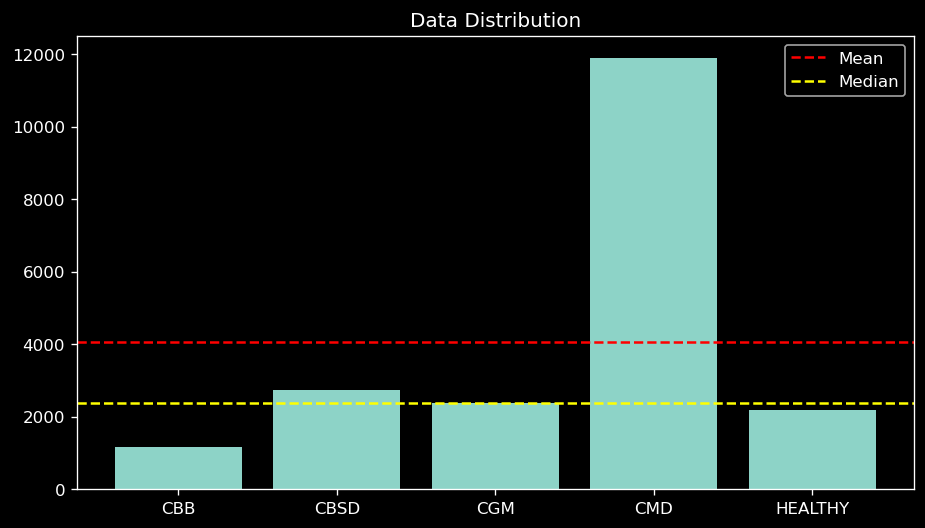

In [9]:
cat_names = ['CBB', 'CBSD', 'CGM', 'CMD', 'HEALTHY']
plt.bar(cat_names, df.loc[:,'label'].value_counts(sort=False))
plt.axhline(df.loc[:,'label'].value_counts().mean(), color='red', ls='--', label='Mean')
plt.axhline(df.loc[:,'label'].value_counts().median(), color='yellow', ls='--', label='Median')
plt.title('Data Distribution')
plt.legend()
plt.show()

<br>
<br>

## Calculate the Relative Weights

Relative Weights: [3.48424658 1.48960469 1.71279461 0.34209818 1.87022059]




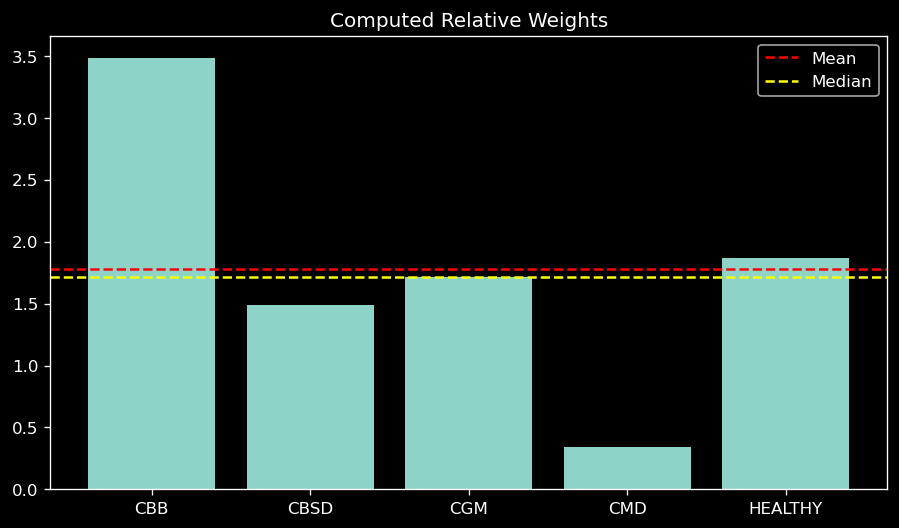

In [10]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', classes=[0,1,2,3,4], y=df.label)
print(f'Relative Weights: {weights}\n\n')

plt.bar(cat_names, weights)
plt.axhline(np.mean(weights), color='red', ls='--', label='Mean')
plt.axhline(np.median(weights), color='yellow', ls='--', label='Median')
plt.title('Computed Relative Weights')
plt.legend()
plt.show()

<br>
<br>

## Hand Tune the outlier weights

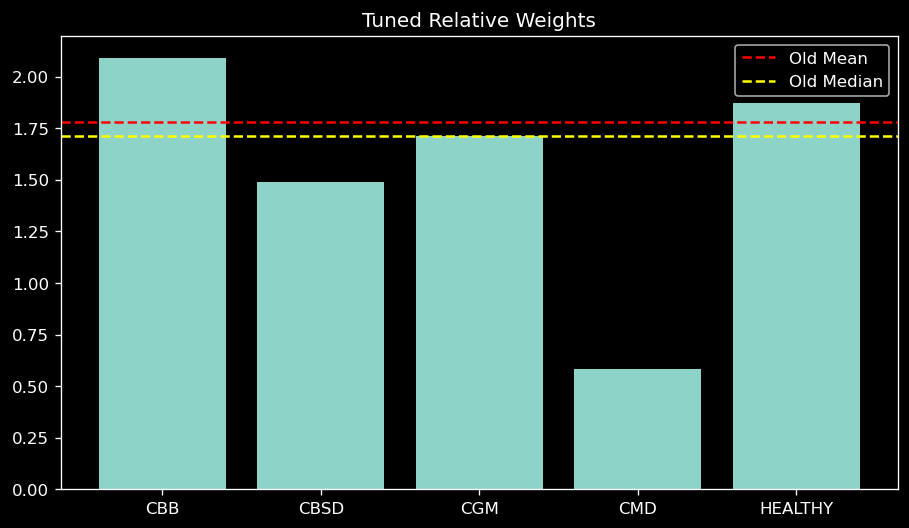

In [11]:
tuned_weights = weights.copy()
tuned_weights[0] = tuned_weights[0] * 0.6
tuned_weights[3] = tuned_weights[3] * 1.7

plt.bar(cat_names, tuned_weights)
plt.axhline(np.mean(weights), color='red', ls='--', label='Old Mean')
plt.axhline(np.median(weights), color='yellow', ls='--', label='Old Median')
plt.title('Tuned Relative Weights')
plt.legend()
plt.show()

<br>
<br>

## Calculate the new Weighted Distribution

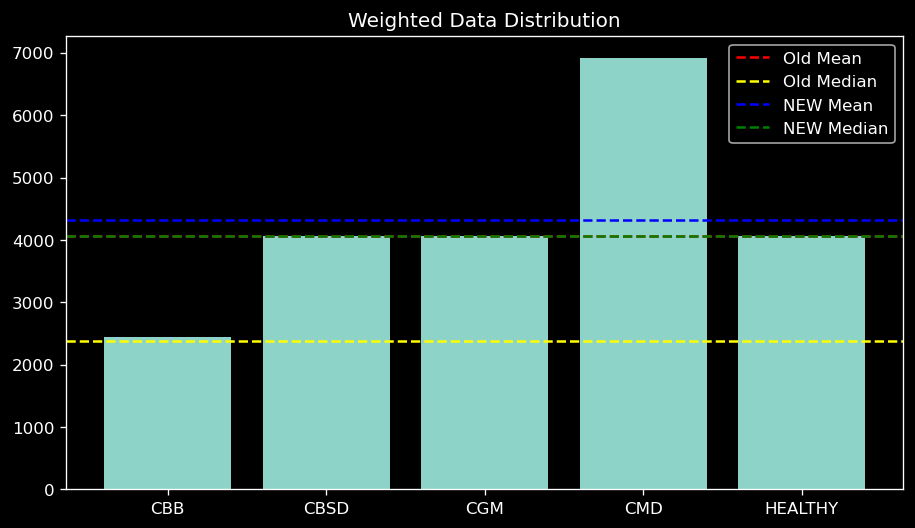

In [12]:
weighted_dist = tuned_weights * df.loc[:,'label'].value_counts(sort=False)

plt.bar(cat_names, weighted_dist)
plt.axhline(df.loc[:,'label'].value_counts().mean(), color='red', ls='--', label='Old Mean')
plt.axhline(df.loc[:,'label'].value_counts().median(), color='yellow', ls='--', label='Old Median')
plt.axhline(np.mean(weighted_dist), color='blue', ls='--', label='NEW Mean')
plt.axhline(np.median(weighted_dist), color='green', ls='--', label='NEW Median')
plt.title('Weighted Data Distribution')
plt.legend()
plt.show()

In [13]:
# convert the tuned weights to a tensor
tuned_weights = Tensor(tuned_weights).cuda()
tuned_weights

tensor([2.0905, 1.4896, 1.7128, 0.5816, 1.8702], device='cuda:0')

<br>
<br>

## Create a list of image paths

In [14]:
train_imgs = L([Path(data_path/'train_images'/f) for f in df.image_id])
random.shuffle(train_imgs)

In [15]:
ensemble_train_imgs = L([Path(data_path/'train_images'/f) for f in ensemble_train_df.image_id])
random.shuffle(ensemble_train_imgs)

<br>
<br>

### Create the DataLoaders

In [16]:
# get the label from any image path  @TODO sloooooowwwwww......

def get_label(o):
    fname = o.name
    if fname in df.image_id.values:
        return df[df.image_id == fname].label.values[0]
    if fname in ensemble_train_df.image_id.values:
        return ensemble_train_df[ensemble_train_df.image_id == fname].label.values[0]


<br>
<br>

## Create the Transforms

In [17]:
item_tfms = [ToTensor(), AlbumentationsTransform(get_train_aug(RESOLUTION), get_valid_aug(RESOLUTION))]
batch_tfms = [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]

<br>
<br>

## Create the Splitter

In [18]:
start_val = len(train_imgs) - int(len(train_imgs) * VALID_PERC)
idcs = list(range(start_val, len(train_imgs)))
splitter = IndexSplitter(idcs)
splits = splitter(train_imgs)
split_list = [splits[0], splits[1]]

split_list.append(L(range(len(train_imgs), len(train_imgs)+len(ensemble_train_imgs))))


In [19]:
split_list

[(#16279) [0,1,2,3,4,5,6,7,8,9...],
 (#4069) [16279,16280,16281,16282,16283,16284,16285,16286,16287,16288...],
 (#4000) [20348,20349,20350,20351,20352,20353,20354,20355,20356,20357...]]

In [20]:
split_list[0][0], split_list[0][-1], split_list[1][0], split_list[1][-1], split_list[2][0]

(0, 16278, 16279, 20347, 20348)

<br>
<br>

## Create the Data Loaders

In [21]:
dsrc = Datasets(train_imgs+ensemble_train_imgs, tfms=[[PILImage.create], [get_label, Categorize]],
                splits = split_list)

dls = dsrc.dataloaders(bs=BATCH_SIZE, after_item=item_tfms, after_batch=batch_tfms)

In [22]:
train_labels = list(df.label.values)
train_labels.extend(ensemble_train_df.label.values)

<br>

### Verify the Training and Validation Batches

examples from the training set


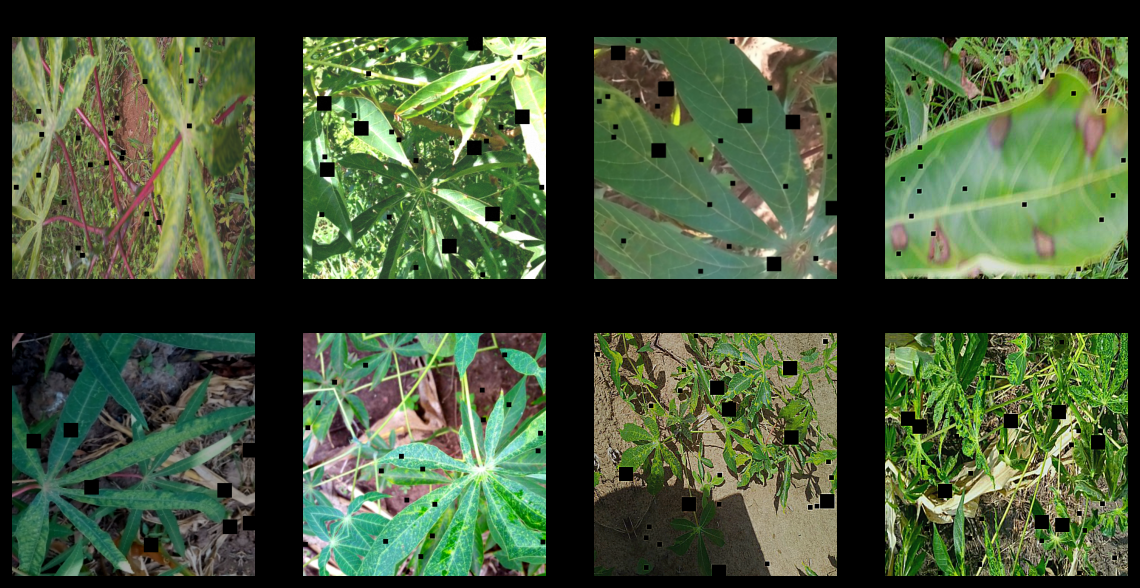

In [23]:
print('examples from the training set')
dls.train.show_batch(max_n=8, nrows=2)


examples from the validation set


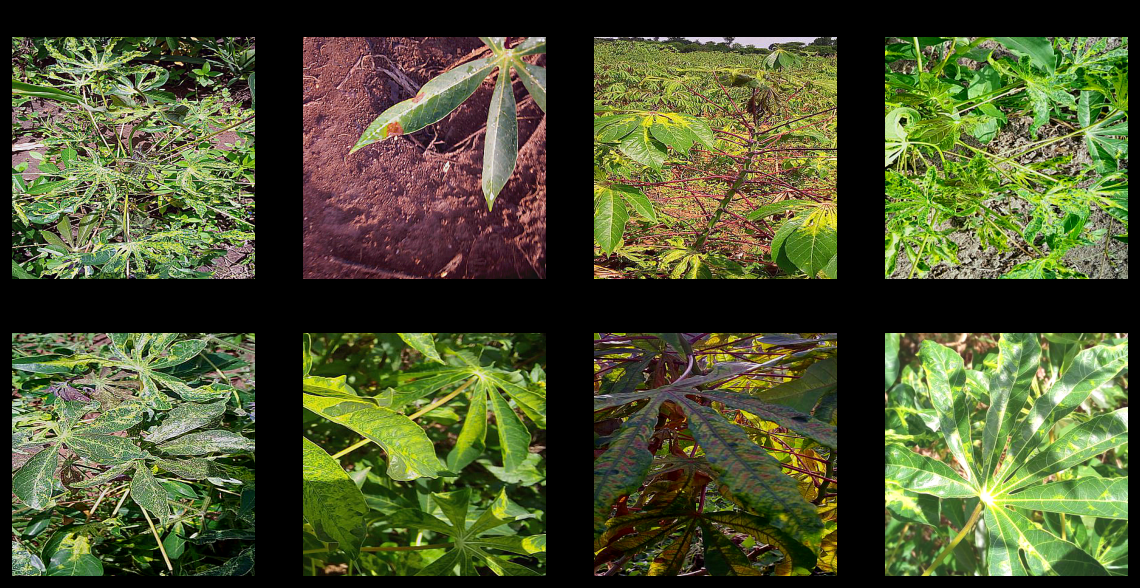

In [24]:
print('\nexamples from the validation set')
dls.valid.show_batch(max_n=8, nrows=2)

<br>
<br>

## Create our Callbacks

In [25]:
cutmix_cb, mixup_cb = None, None

def create_callbacks():

    # Eary stopping callback
    early_stop_cb = EarlyStoppingCallback(monitor='valid_loss', min_delta=0.001, patience=4, reset_on_fit=False)

    # Save the current model's weights every epoch
    save_cb = SaveModelCallback(fname=RUN_NAME, with_opt=True)

    # Reduce the Learning Rate if valid_loss flatlines
    reduceLR_cb = ReduceLROnPlateau(monitor='valid_loss', min_delta=0.01, min_lr=1e-8, patience=2, factor=10, reset_on_fit=False)

    # Mixup callback for regularization
    # mixup_cb = MixUp(alpha=0.3)
    mixup_cb = None

    # Cutmix callback for regularization
    cutmix_cb = CutMix(alpha=1.0)
    # cutmix_cb = None

    # Gradient Accumulation
    # gradacc_cb =  GradientAccumulation(n_acc=16)
    gradacc_cb =  GradientAccumulation(n_acc=64)
  
    # log our runs
    csv_log_cb = CSVLogger(fname=f'CSV-History/{RUN_NAME}.csv', append=True)


    # List of callbacks to be used later
    cbs = [save_cb, ShowGraphCallback(), early_stop_cb, GradientClip, gradacc_cb]  #, csv_log_cb] #, reduceLR_cb]

    if mixup_cb != None:
        cbs.insert(0, mixup_cb)

    if cutmix_cb != None:
        cbs.insert(0, cutmix_cb)

    print('\nAll Callbacks: ', cbs)
    
    return cbs

### Visualize the effect of CutMix


In [26]:
if cutmix_cb != None:
    with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=cutmix_cb) as learn:
        learn.epoch,learn.training = 0,True
        learn.dl = dls.train
        b = dls.one_batch()
        learn._split(b)
        learn('before_batch')

    _,axs = plt.subplots(3,3, figsize=(9,9))
    dls.show_batch(b=(cutmix_cb.x,cutmix_cb.y), ctxs=axs.flatten())
    
else: print('\n CutMix was not selected.')


 CutMix was not selected.


<br>

### Visualize the Effect of MixUp

MixUp creates a linear interpolation between the target data and another datapoint.  In images, it shows up as ghostly figures.  The technique has been shown to be a good to decrease the liklihood of overfitting.

In [27]:
if mixup_cb != None:
    with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=mixup_cb) as learn:
        learn.epoch,learn.training = 0,True
        learn.dl = dls.train
        b = dls.one_batch()
        learn._split(b)
        learn('before_batch')

    _,axs = plt.subplots(3,3, figsize=(9,9))
    dls.show_batch(b=(mixup_cb.x,mixup_cb.y), ctxs=axs.flatten())

else: print('\n MixUp was not selected.')


 MixUp was not selected.


In [28]:
import timm

def create_learner(cat_weights=None):
    # Create the learner
    learn = timm_learner(dls, 
                         ARCH,
                         opt_func=ranger,
                         loss_func=LabelSmoothingCrossEntropyFlat(weight=cat_weights),
                         cbs=create_callbacks(), 
                         pretrained=PRETRAINED_FLAG,
                         metrics = [error_rate, accuracy, RocAuc()]
                        )


    # Learner Surgery - replacing modules
    learn = convert_MP_to_blurMP(learn, nn.MaxPool2d)  # doesn't exist!
    learn.model = convert_act_cls(learn.model, nn.ReLU, MishAuto())  # very expensive so we only use it on the head
#     learn.model = convert_act_cls(learn.model, nn.SiLU, SwishAuto())  # replace with a lower memory version
    
#     learn = learn.to_fp16()  # convert to 16bit
    learn = learn.to_non_native_fp16()

    return learn


In [29]:
learn = create_learner()


All Callbacks:  [CutMix, SaveModelCallback, ShowGraphCallback, EarlyStoppingCallback, <class 'fastai.callback.training.GradientClip'>, GradientAccumulation]


In [30]:
display(learn.loss_func, learn.opt_func, learn.cbs) #, '-------------------------------------', learn.model)  # Checkpoint

FlattenedLoss of LabelSmoothingCrossEntropy()

<function fastai.optimizer.ranger(p, lr, mom=0.95, wd=0.01, eps=1e-06, sqr_mom=0.99, beta=0.0, decouple_wd=True)>

(#11) [TrainEvalCallback,Recorder,ProgressCallback,CutMix,SaveModelCallback,ShowGraphCallback,EarlyStoppingCallback,GradientClip,GradientAccumulation,ModelToHalf...]

In [31]:
learn.model[1]

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): MishAuto()
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=5, bias=False)
)

In [32]:
# # RUN_NAME_OF_MODEL_TO_LOAD = '20210211-0115 - arch=tf_efficientnet_b4_ns - samples=1800 frozen=1 epochs=15 bs=12 res=460'
# EPOCH_TO_LOAD = 7

# load_model(f'models/{RUN_NAME_OF_MODEL_TO_LOAD}.pth', learn, opt=ranger, with_opt=True)



# <br>
<br>
<br>
<br>

# ------------------ RUN TO HERE -------------------

<br>
<br>
<br>

## Find a Good Learning Rate to Start With

In [33]:
LR_DIV = 14e0  # Shift the lr_min left by this amount.  Adjust as necessary
lr_min = 0.002  # just a default

In [34]:
# from apex.fp16_utils import convert_network
# learn.model = convert_network(learn.model, torch.float16)

In [35]:
# learn = learn.to_fp16()

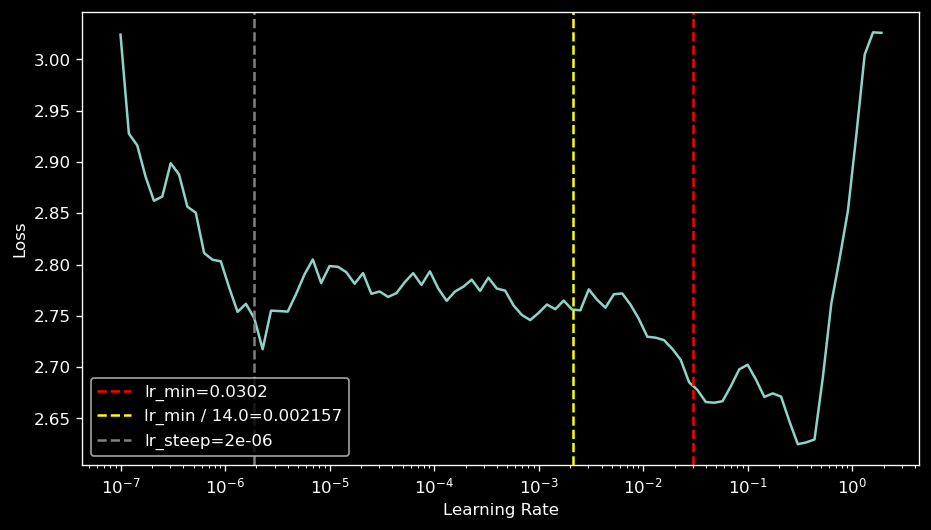

Minimum/10: 3.02e-02, steepest point: 1.91e-06, (Mim/10)/14.0: 0.0021571082728249684


In [36]:
if PRETRAINED_FLAG == True:
    learn.freeze()
    lr_min,lr_steep = learn.lr_find()
    plt.axvline(lr_min, ls='--', color='red', label=f'lr_min={round(lr_min,6)}')
    plt.axvline(lr_min/LR_DIV, ls='--', color='yellow', label=f'lr_min / {LR_DIV}={round(lr_min/LR_DIV,6)}')
    plt.axvline(lr_steep, ls='--', color='grey', label=f'lr_steep={round(lr_steep,6)}')
    plt.legend()
    plt.show()

    print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}, (Mim/10)/{LR_DIV}: {lr_min/LR_DIV}")

<br>
<br>

# Pick a Good Initial Learning Rate

In [37]:
# LR_CHOICE = lr_min/LR_DIV
# LR_CHOICE = lr_steep
# LR_CHOICE = 9e-3
# LR_CHOICE = 2e-4
LR_CHOICE = min(3e-2, lr_min)
# LR_CHOICE=1e-3

<br>
<br>

<br>
<br>

# Training the Model

<br>

## Fit the last layers, unfreeze, fit the whole net, with a decent initial LR, all in one go.



In [38]:
if PRETRAINED_FLAG:
    print(f'FROZEN_EPOCHS:  {FROZEN_EPOCHS}')
print(f'EPOCHS:         {EPOCHS}')
print(f'Learning Rate:  {LR_CHOICE}\n\n')

FROZEN_EPOCHS:  1
EPOCHS:         5
Learning Rate:  0.03




Better model found at epoch 0 with valid_loss value: 1.0907397270202637.


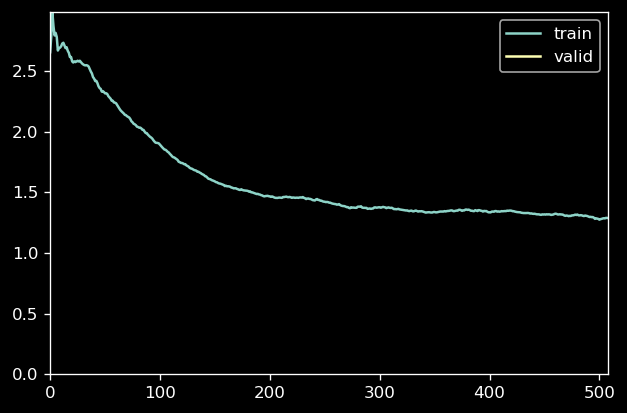

Max GPU Memory Allocated: 3.401445376 GB


In [39]:
if PRETRAINED_FLAG:
    learn.fit_flat_cos(FROZEN_EPOCHS, LR_CHOICE, pct_start=0.99, wd=0.1, reset_opt=True)
#     fit_hump(learn, 1, lr_max=LR_CHOICE, reset_opt=True)
#     learn.fit_one_cycle(FROZEN_EPOCHS, slice(LR_CHOICE), wd=0.1)

    print(f'Max GPU Memory Allocated: {torch.cuda.max_memory_allocated()/1000000000} GB')
    torch.cuda.reset_max_memory_allocated()

<br>
<br>

## Manually set up the unfrozen runs

In [40]:
learn.unfreeze()

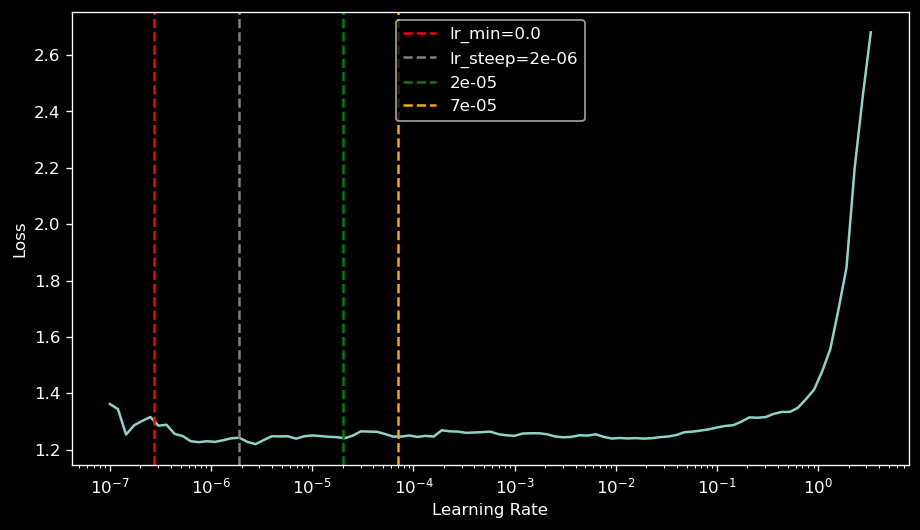

In [41]:
lr_min,lr_steep = learn.lr_find()
plt.axvline(lr_min, ls='--', color='red', label=f'lr_min={round(lr_min,6)}')
# plt.axvline(LR_CHOICE/2, ls='--', color='yellow', label=f'LR_CHOICE/2={round(LR_CHOICE/2,6)}')
plt.axvline(lr_steep, ls='--', color='grey', label=f'lr_steep={round(lr_steep,6)}')
plt.axvline(2e-5, ls='--', color='green', label=f'{round(2e-5,6)}')
plt.axvline(7e-5, ls='--', color='orange', label=f'{round(7e-5,6)}')

plt.legend()
plt.show()

In [42]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")  #, LR_CHOICE/2: {LR_CHOICE / 2}")

Minimum/10: 2.75e-07, steepest point: 1.91e-06


In [43]:
# Persist a Copy

# Need to do this first as it won't pickle
# learn.remove_cbs(CSVLogger)

learn.export(f'models/STAGE1_{RUN_NAME}.pkl')
print(f'Saved to: models/STAGE1_{RUN_NAME}.pkl')

# put the logger back in
# learn.add_cbs(CSVLogger(fname=f'{RUN_NAME}.csv', append=True))

Saved to: models/STAGE1_20210223-0550 - arch=densenetblur121d - samples=-1 frozen=1 epochs=5 bs=32 res=300.pkl


## Pick a new Learning Rate

In [44]:
# LR_CHOICE_UNFROZ = 9e-3
# LR_CHOICE_UNFROZ = 3e-3
# LR_CHOICE_UNFROZ = 4e-3
# LR_CHOICE_UNFROZ = 6e-3
# LR_CHOICE_UNFROZ = 5e-4
LR_CHOICE_UNFROZ = 2e-3



### Train

In [45]:
EPOCHS = 30

In [46]:
print(f'EPOCHS:         {EPOCHS}')
print(f'Learning Rate:  {LR_CHOICE_UNFROZ}\n\n')

EPOCHS:         30
Learning Rate:  0.002




Better model found at epoch 0 with valid_loss value: 0.8685280084609985.


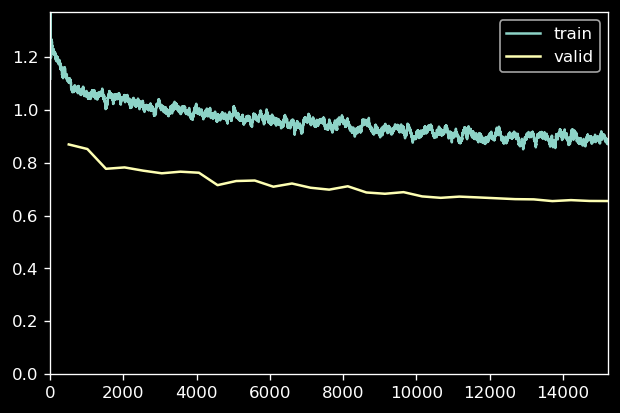

Better model found at epoch 1 with valid_loss value: 0.8512575626373291.
Better model found at epoch 2 with valid_loss value: 0.776522159576416.
Better model found at epoch 4 with valid_loss value: 0.7694777250289917.
Better model found at epoch 5 with valid_loss value: 0.7595462203025818.
Better model found at epoch 8 with valid_loss value: 0.7147847414016724.
Better model found at epoch 11 with valid_loss value: 0.7088766694068909.
Better model found at epoch 13 with valid_loss value: 0.7049784660339355.
Better model found at epoch 14 with valid_loss value: 0.6977999806404114.
Better model found at epoch 16 with valid_loss value: 0.6871129870414734.
Better model found at epoch 17 with valid_loss value: 0.6822396516799927.
Better model found at epoch 19 with valid_loss value: 0.6722384095191956.
Better model found at epoch 20 with valid_loss value: 0.6668423414230347.
Better model found at epoch 23 with valid_loss value: 0.6651718616485596.
Better model found at epoch 24 with valid_lo

In [47]:
# learn.fit_flat_cos(EPOCHS, slice(LR_CHOICE_UNFROZ), pct_start=0.68)

# learn.fit_one_cycle(EPOCHS, slice(LR_CHOICE_UNFROZ),  wd=1e-2)

learn.fit_flat_cos(EPOCHS, LR_CHOICE_UNFROZ, pct_start=0.1, wd=1e-2, reset_opt=False)
# fit_hump(learn, EPOCHS, lr_max=LR_CHOICE_UNFROZ, reset_opt=True)

print(f'Max GPU Memory Allocated: {torch.cuda.max_memory_allocated()/1000000000} GB')
torch.cuda.reset_max_memory_allocated()

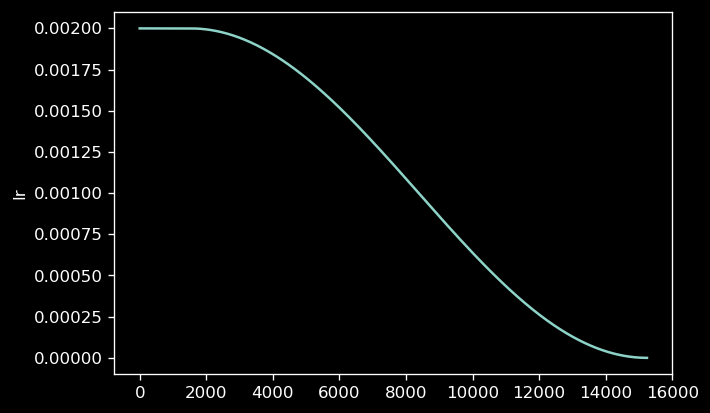

In [48]:
learn.recorder.plot_sched()

In [49]:
learn.save(f'{RUN_NAME}_model1_acc{round(learn.validate(ds_idx=2)[2],2)}')

Better model found at epoch 0 with valid_loss value: 0.12150000035762787.


Path('models/20210223-0550 - arch=densenetblur121d - samples=-1 frozen=1 epochs=5 bs=32 res=300_model1_acc0.88.pth')

<br>
<br>

# Cross-Validate + Ensemble

-----------------------------------
------------ SPLIT 1 ------------
-----------------------------------

All Callbacks:  [CutMix, SaveModelCallback, ShowGraphCallback, EarlyStoppingCallback, <class 'fastai.callback.training.GradientClip'>, GradientAccumulation]


Better model found at epoch 0 with valid_loss value: 1.2610424757003784.


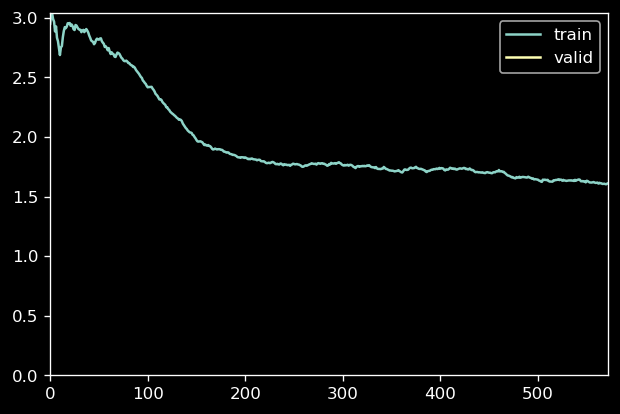

Better model found at epoch 0 with valid_loss value: 0.3557499945163727.
Saved to: ../models/20210223-0550 - arch=densenetblur121d - samples=-1 frozen=1 epochs=5 bs=32 res=300_split_1.pkl
------> EPOCH: 5


Better model found at epoch 0 with valid_loss value: 1.054439663887024.


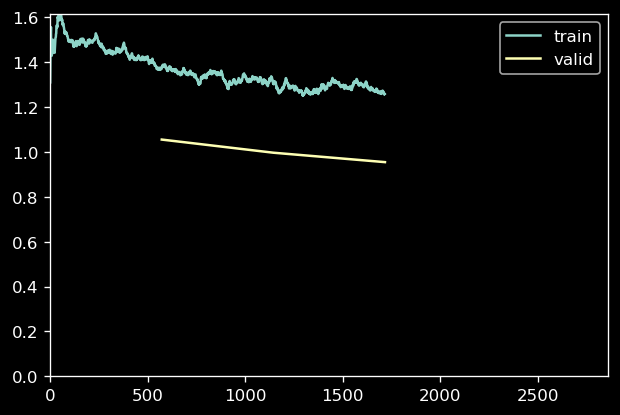

Better model found at epoch 1 with valid_loss value: 0.9959442615509033.
Better model found at epoch 2 with valid_loss value: 0.9539538621902466.
Better model found at epoch 3 with valid_loss value: 0.8859149217605591.
No improvement since epoch -1: early stopping


Better model found at epoch 0 with valid_loss value: 0.18074999749660492.


Better model found at epoch 0 with valid_loss value: 0.1864476352930069.


Better model found at epoch 0 with valid_loss value: 0.18074999749660492.
Validation on test: [0.863157331943512, 0.18074999749660492, 0.8192499876022339, 0.9516993154048178]
------> EPOCH: 10


Better model found at epoch 0 with valid_loss value: 0.9148257970809937.


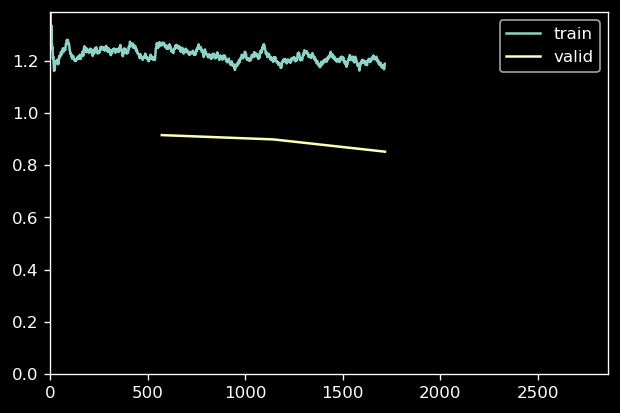

Better model found at epoch 1 with valid_loss value: 0.89838707447052.
Better model found at epoch 2 with valid_loss value: 0.8514819741249084.
Better model found at epoch 3 with valid_loss value: 0.8294975757598877.
No improvement since epoch -1: early stopping


Better model found at epoch 0 with valid_loss value: 0.1420000046491623.


Better model found at epoch 0 with valid_loss value: 0.14127309620380402.


Better model found at epoch 0 with valid_loss value: 0.1420000046491623.
Validation on test: [0.8011219501495361, 0.1420000046491623, 0.8579999804496765, 0.9622153598607358]
------> EPOCH: 15


Better model found at epoch 0 with valid_loss value: 0.8581147789955139.


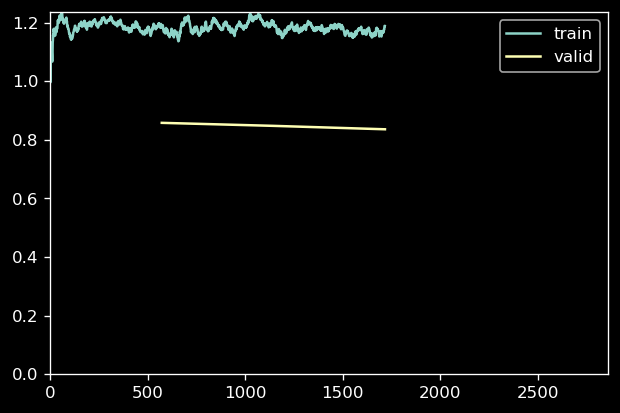

Better model found at epoch 1 with valid_loss value: 0.8478492498397827.
Better model found at epoch 2 with valid_loss value: 0.8361465334892273.
Better model found at epoch 3 with valid_loss value: 0.8010881543159485.
No improvement since epoch -1: early stopping


Better model found at epoch 0 with valid_loss value: 0.14775000512599945.


Better model found at epoch 0 with valid_loss value: 0.1482546180486679.


Better model found at epoch 0 with valid_loss value: 0.14624999463558197.
Validation on test: [0.7712468504905701, 0.14624999463558197, 0.8537499904632568, 0.9658318545742601]
------> EPOCH: 20


Better model found at epoch 0 with valid_loss value: 0.8371498584747314.


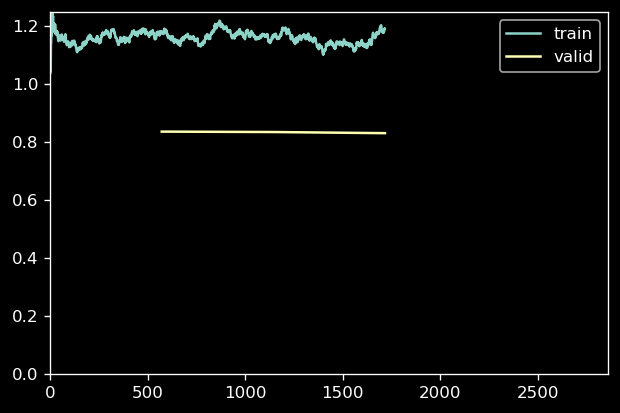

Better model found at epoch 1 with valid_loss value: 0.835702657699585.
Better model found at epoch 2 with valid_loss value: 0.831779956817627.
Better model found at epoch 3 with valid_loss value: 0.7987581491470337.
No improvement since epoch -1: early stopping


Better model found at epoch 0 with valid_loss value: 0.13950000703334808.


Better model found at epoch 0 with valid_loss value: 0.1531827449798584.


Better model found at epoch 0 with valid_loss value: 0.13750000298023224.
Validation on test: [0.7814239859580994, 0.13750000298023224, 0.862500011920929, 0.9645575695505176]
------> EPOCH: 25


Better model found at epoch 0 with valid_loss value: 0.8287317156791687.


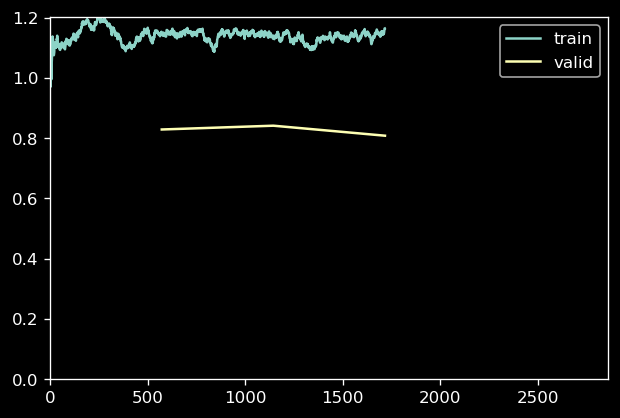

Better model found at epoch 2 with valid_loss value: 0.8081223368644714.
Better model found at epoch 3 with valid_loss value: 0.7898240685462952.
No improvement since epoch -1: early stopping


Better model found at epoch 0 with valid_loss value: 0.15000000596046448.


Better model found at epoch 0 with valid_loss value: 0.14373716711997986.


Better model found at epoch 0 with valid_loss value: 0.14374999701976776.
Validation on test: [0.7681127190589905, 0.14374999701976776, 0.856249988079071, 0.9636345648762799]


Better model found at epoch 0 with valid_loss value: 0.14784394204616547.


-----------------------------------
------------ SPLIT 2 ------------
-----------------------------------

All Callbacks:  [CutMix, SaveModelCallback, ShowGraphCallback, EarlyStoppingCallback, <class 'fastai.callback.training.GradientClip'>, GradientAccumulation]


Better model found at epoch 0 with valid_loss value: 1.0432015657424927.


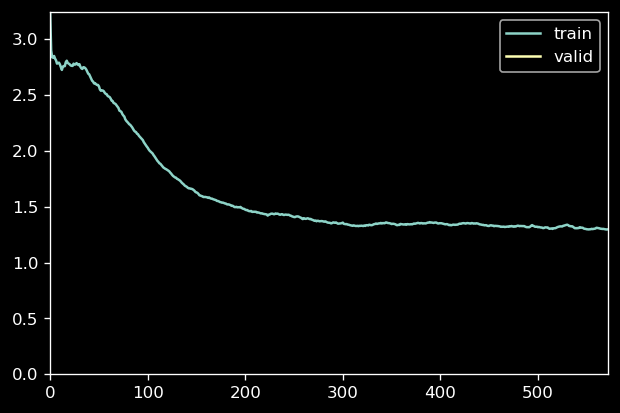

Better model found at epoch 0 with valid_loss value: 0.29124999046325684.
Saved to: ../models/20210223-0550 - arch=densenetblur121d - samples=-1 frozen=1 epochs=5 bs=32 res=300_split_2.pkl
------> EPOCH: 5


Better model found at epoch 0 with valid_loss value: 0.859754204750061.


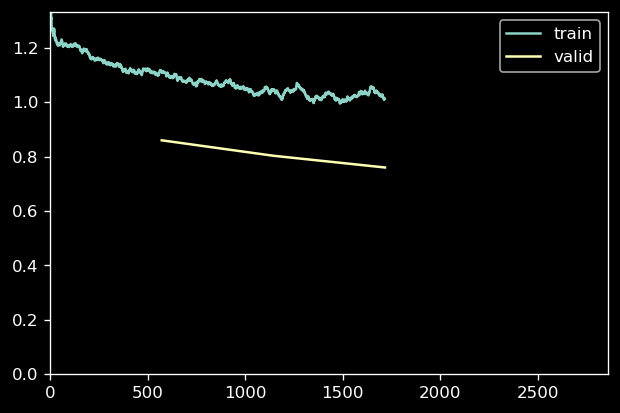

Better model found at epoch 1 with valid_loss value: 0.8030135035514832.
Better model found at epoch 2 with valid_loss value: 0.7599263191223145.
Better model found at epoch 3 with valid_loss value: 0.7307687401771545.
No improvement since epoch -1: early stopping


Better model found at epoch 0 with valid_loss value: 0.14900000393390656.


Better model found at epoch 0 with valid_loss value: 0.15482546389102936.


Better model found at epoch 0 with valid_loss value: 0.14775000512599945.
Validation on test: [0.7106900811195374, 0.14775000512599945, 0.8522499799728394, 0.9647389675861048]
------> EPOCH: 10


Better model found at epoch 0 with valid_loss value: 0.7496150732040405.


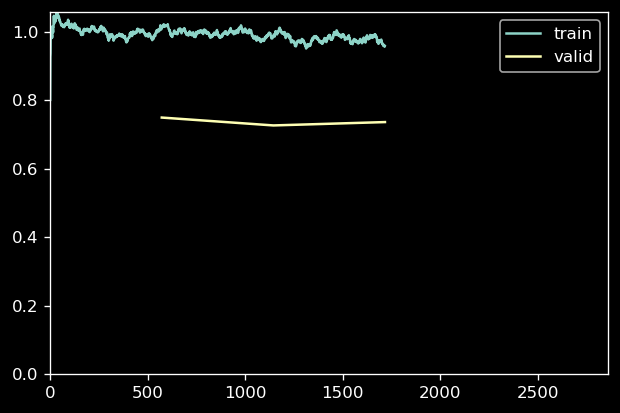

Better model found at epoch 1 with valid_loss value: 0.7266291379928589.
Better model found at epoch 3 with valid_loss value: 0.6991371512413025.
No improvement since epoch -1: early stopping


Better model found at epoch 0 with valid_loss value: 0.13375000655651093.


Better model found at epoch 0 with valid_loss value: 0.13264887034893036.


Better model found at epoch 0 with valid_loss value: 0.13224999606609344.
Validation on test: [0.6835123896598816, 0.13224999606609344, 0.8677499890327454, 0.9676548822006433]
------> EPOCH: 15


Better model found at epoch 0 with valid_loss value: 0.7215452790260315.


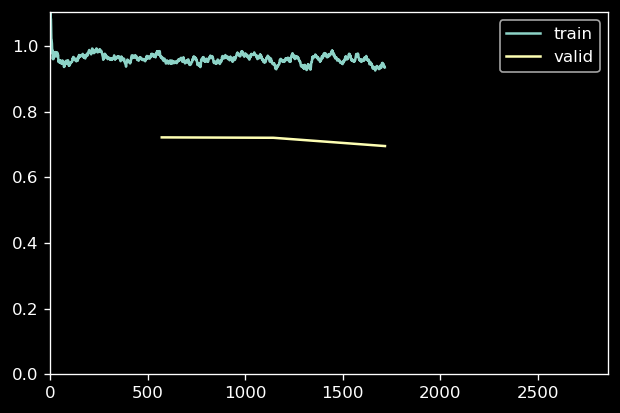

Better model found at epoch 1 with valid_loss value: 0.7203270196914673.
Better model found at epoch 2 with valid_loss value: 0.6951248645782471.
Better model found at epoch 3 with valid_loss value: 0.6823663115501404.
No improvement since epoch -1: early stopping


Better model found at epoch 0 with valid_loss value: 0.12425000220537186.


Better model found at epoch 0 with valid_loss value: 0.12689939141273499.


Better model found at epoch 0 with valid_loss value: 0.11874999850988388.
Validation on test: [0.6616877913475037, 0.11874999850988388, 0.8812500238418579, 0.9700995007076937]
------> EPOCH: 20


Better model found at epoch 0 with valid_loss value: 0.6988622546195984.


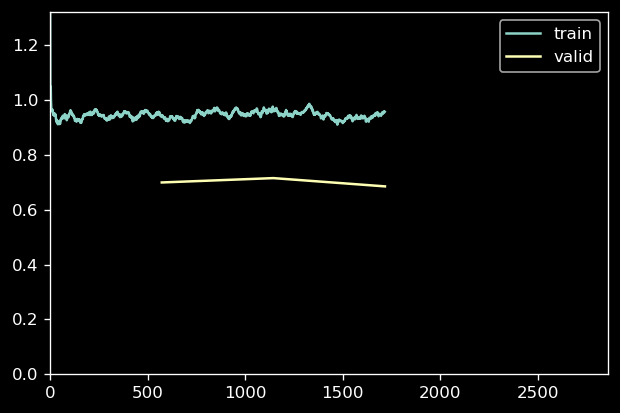

Better model found at epoch 2 with valid_loss value: 0.6846160292625427.
Better model found at epoch 3 with valid_loss value: 0.6779251098632812.
No improvement since epoch -1: early stopping


Better model found at epoch 0 with valid_loss value: 0.12150000035762787.


Better model found at epoch 0 with valid_loss value: 0.12936344742774963.


Better model found at epoch 0 with valid_loss value: 0.11900000274181366.
Validation on test: [0.6547120213508606, 0.11900000274181366, 0.8809999823570251, 0.9726620569102614]
------> EPOCH: 25


Better model found at epoch 0 with valid_loss value: 0.7075004577636719.


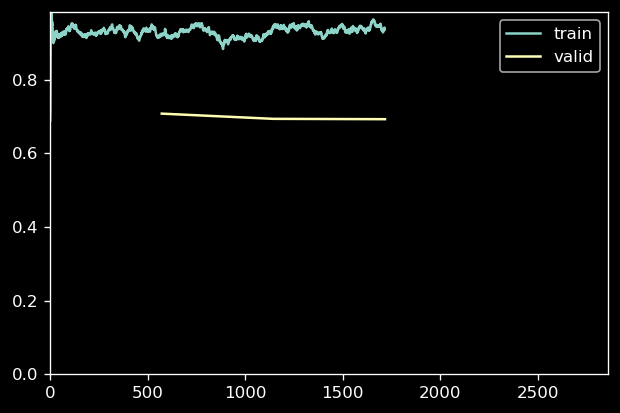

Better model found at epoch 1 with valid_loss value: 0.6933690309524536.
Better model found at epoch 2 with valid_loss value: 0.6924243569374084.
No improvement since epoch -1: early stopping


Better model found at epoch 0 with valid_loss value: 0.12549999356269836.


Better model found at epoch 0 with valid_loss value: 0.13593429327011108.


Better model found at epoch 0 with valid_loss value: 0.13224999606609344.
Validation on test: [0.6786797046661377, 0.13224999606609344, 0.8677499890327454, 0.9675123369444153]


Better model found at epoch 0 with valid_loss value: 0.13552361726760864.


-----------------------------------
------------ SPLIT 3 ------------
-----------------------------------

All Callbacks:  [CutMix, SaveModelCallback, ShowGraphCallback, EarlyStoppingCallback, <class 'fastai.callback.training.GradientClip'>, GradientAccumulation]


Better model found at epoch 0 with valid_loss value: 1.29996657371521.


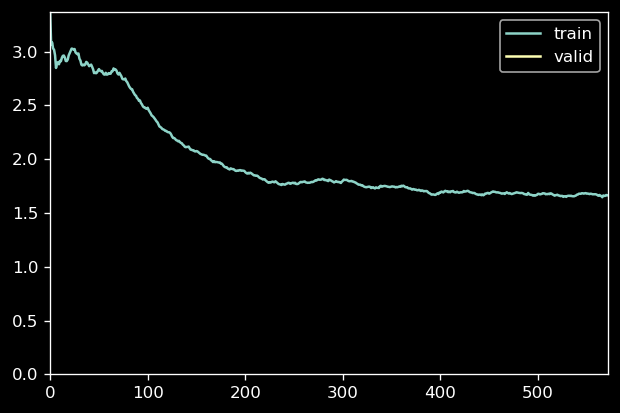

Better model found at epoch 0 with valid_loss value: 0.4345000088214874.
Saved to: ../models/20210223-0550 - arch=densenetblur121d - samples=-1 frozen=1 epochs=5 bs=32 res=300_split_3.pkl
------> EPOCH: 5


Better model found at epoch 0 with valid_loss value: 1.0774880647659302.


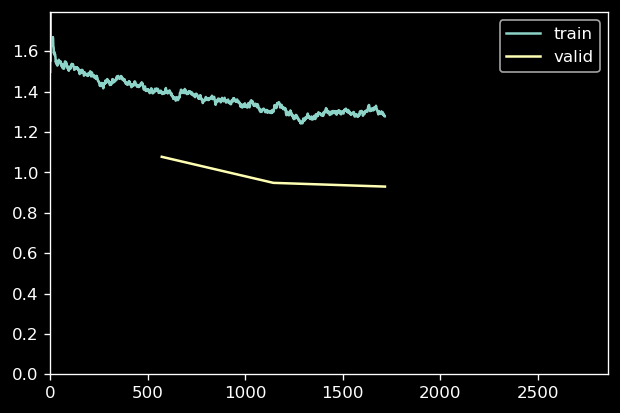

Better model found at epoch 1 with valid_loss value: 0.9484500288963318.
Better model found at epoch 2 with valid_loss value: 0.9299899935722351.
Better model found at epoch 3 with valid_loss value: 0.8629809617996216.
No improvement since epoch -1: early stopping


Better model found at epoch 0 with valid_loss value: 0.17374999821186066.


Better model found at epoch 0 with valid_loss value: 0.17700205743312836.


Better model found at epoch 0 with valid_loss value: 0.17949999868869781.
Validation on test: [0.8535440564155579, 0.17949999868869781, 0.8205000162124634, 0.9536832244140369]
------> EPOCH: 10


Better model found at epoch 0 with valid_loss value: 0.9667630791664124.


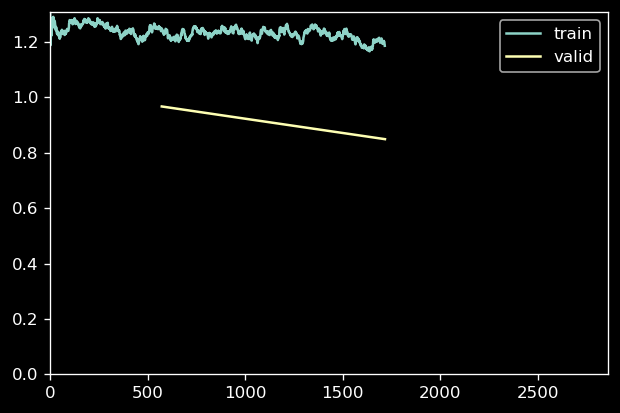

Better model found at epoch 1 with valid_loss value: 0.9076542854309082.
Better model found at epoch 2 with valid_loss value: 0.8487515449523926.
Better model found at epoch 3 with valid_loss value: 0.811461865901947.
No improvement since epoch -1: early stopping


Better model found at epoch 0 with valid_loss value: 0.15299999713897705.


Better model found at epoch 0 with valid_loss value: 0.14743326604366302.


Better model found at epoch 0 with valid_loss value: 0.1535000056028366.
Validation on test: [0.7991130948066711, 0.1535000056028366, 0.8464999794960022, 0.956572113672484]
------> EPOCH: 15


Better model found at epoch 0 with valid_loss value: 0.8550139665603638.


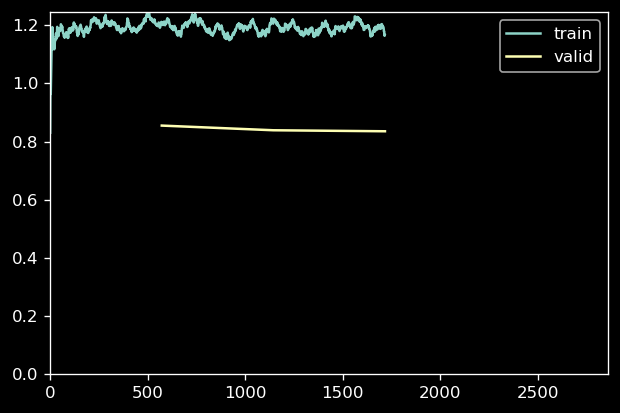

Better model found at epoch 1 with valid_loss value: 0.8389620780944824.
Better model found at epoch 2 with valid_loss value: 0.8355026841163635.
Better model found at epoch 3 with valid_loss value: 0.7929623126983643.
No improvement since epoch -1: early stopping


Better model found at epoch 0 with valid_loss value: 0.148499995470047.


Better model found at epoch 0 with valid_loss value: 0.1420944631099701.


Better model found at epoch 0 with valid_loss value: 0.1522500067949295.
Validation on test: [0.8061441779136658, 0.1522500067949295, 0.8477500081062317, 0.9562568950689763]
------> EPOCH: 20


Better model found at epoch 0 with valid_loss value: 0.8679214119911194.


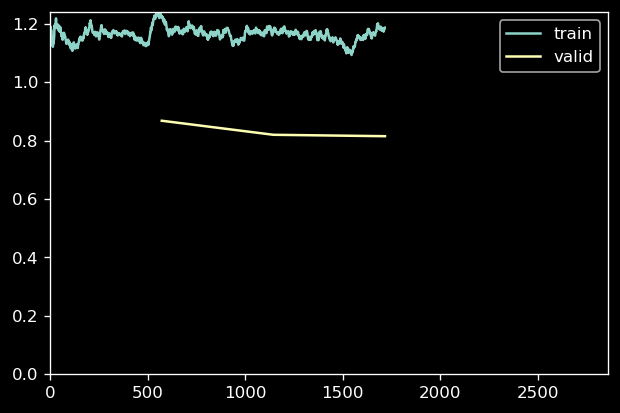

Better model found at epoch 1 with valid_loss value: 0.8198369741439819.
Better model found at epoch 2 with valid_loss value: 0.815032958984375.
Better model found at epoch 3 with valid_loss value: 0.7711527347564697.
No improvement since epoch -1: early stopping


Better model found at epoch 0 with valid_loss value: 0.14374999701976776.


Better model found at epoch 0 with valid_loss value: 0.13182751834392548.


Better model found at epoch 0 with valid_loss value: 0.14274999499320984.
Validation on test: [0.7635822892189026, 0.14274999499320984, 0.8572499752044678, 0.9636864847876033]
------> EPOCH: 25


Better model found at epoch 0 with valid_loss value: 0.8120563626289368.


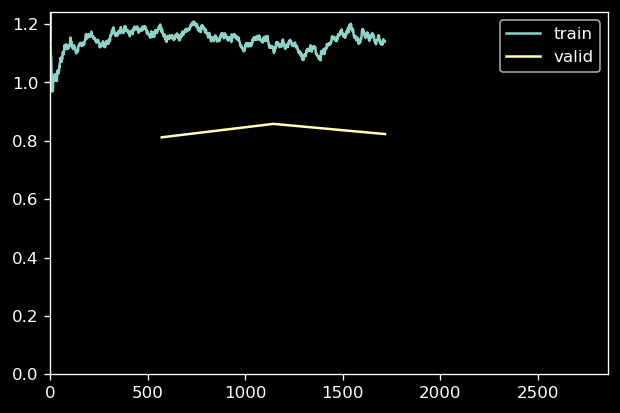

Better model found at epoch 3 with valid_loss value: 0.7836949229240417.
No improvement since epoch -1: early stopping


Better model found at epoch 0 with valid_loss value: 0.14374999701976776.


Better model found at epoch 0 with valid_loss value: 0.14743326604366302.


Better model found at epoch 0 with valid_loss value: 0.14925000071525574.
Validation on test: [0.7607522010803223, 0.14925000071525574, 0.8507500290870667, 0.9650016898170289]


Better model found at epoch 0 with valid_loss value: 0.14661191403865814.


-----------------------------------
------------ SPLIT 4 ------------
-----------------------------------

All Callbacks:  [CutMix, SaveModelCallback, ShowGraphCallback, EarlyStoppingCallback, <class 'fastai.callback.training.GradientClip'>, GradientAccumulation]


Better model found at epoch 0 with valid_loss value: 1.0714168548583984.


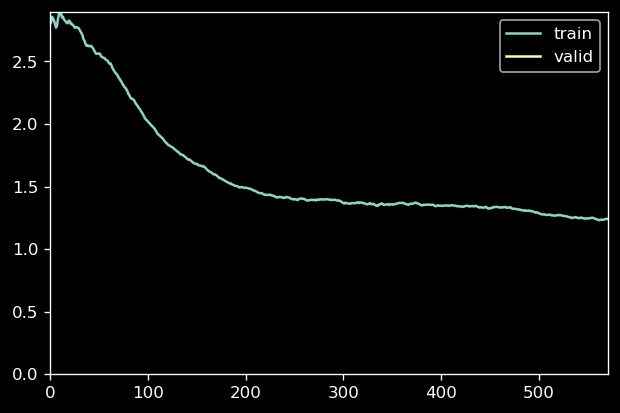

Better model found at epoch 0 with valid_loss value: 0.32374998927116394.
Saved to: ../models/20210223-0550 - arch=densenetblur121d - samples=-1 frozen=1 epochs=5 bs=32 res=300_split_4.pkl
------> EPOCH: 5


Better model found at epoch 0 with valid_loss value: 0.8481863141059875.


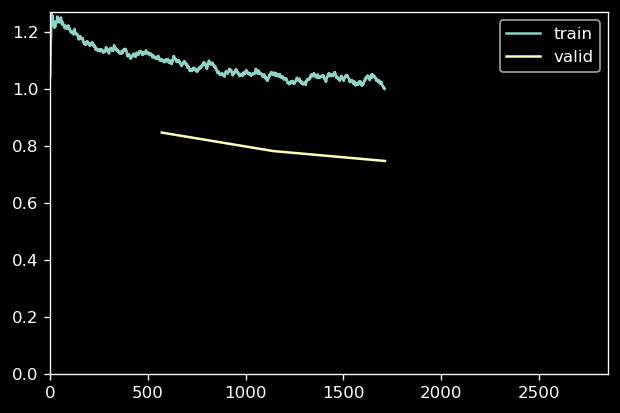

Better model found at epoch 1 with valid_loss value: 0.7832868695259094.
Better model found at epoch 2 with valid_loss value: 0.7485631108283997.
Better model found at epoch 3 with valid_loss value: 0.7262945175170898.
No improvement since epoch -1: early stopping


Better model found at epoch 0 with valid_loss value: 0.15549999475479126.


Better model found at epoch 0 with valid_loss value: 0.16098563373088837.


Better model found at epoch 0 with valid_loss value: 0.1509999930858612.
Validation on test: [0.7137956619262695, 0.1509999930858612, 0.8489999771118164, 0.961389571063091]
------> EPOCH: 10


Better model found at epoch 0 with valid_loss value: 0.7570500373840332.


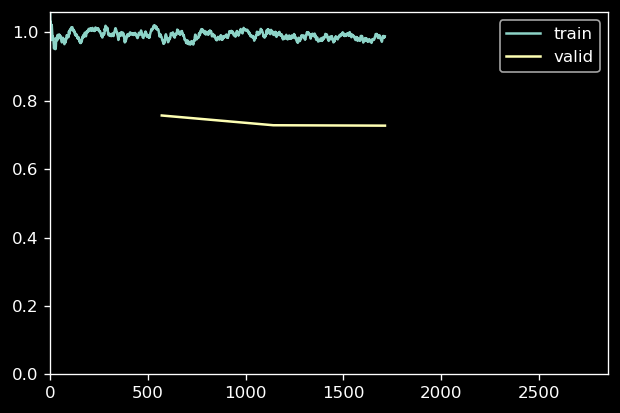

Better model found at epoch 1 with valid_loss value: 0.7285311222076416.
Better model found at epoch 2 with valid_loss value: 0.7273618578910828.
Better model found at epoch 3 with valid_loss value: 0.7047358751296997.
No improvement since epoch -1: early stopping


Better model found at epoch 0 with valid_loss value: 0.1404999941587448.


Better model found at epoch 0 with valid_loss value: 0.1482546180486679.


Better model found at epoch 0 with valid_loss value: 0.1407500058412552.
Validation on test: [0.6921215057373047, 0.1407500058412552, 0.859250009059906, 0.9611808628606054]
------> EPOCH: 15


Better model found at epoch 0 with valid_loss value: 0.7148889303207397.


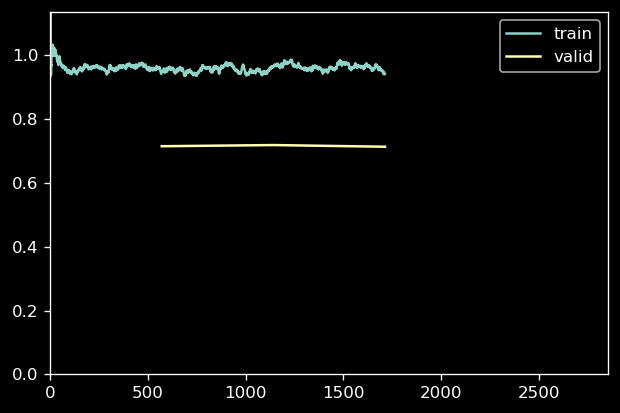

Better model found at epoch 2 with valid_loss value: 0.7133377194404602.
Better model found at epoch 3 with valid_loss value: 0.6955186724662781.
No improvement since epoch -1: early stopping


Better model found at epoch 0 with valid_loss value: 0.1379999965429306.


Better model found at epoch 0 with valid_loss value: 0.13182751834392548.


Better model found at epoch 0 with valid_loss value: 0.1392499953508377.
Validation on test: [0.6854182481765747, 0.1392499953508377, 0.8607500195503235, 0.9675186420136491]
------> EPOCH: 20


Better model found at epoch 0 with valid_loss value: 0.704048752784729.


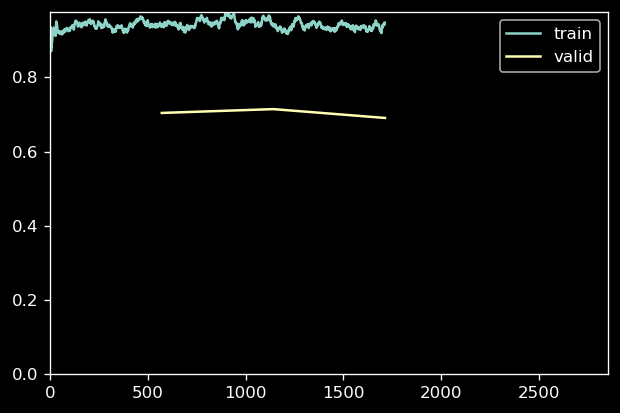

Better model found at epoch 2 with valid_loss value: 0.6905623078346252.
Better model found at epoch 3 with valid_loss value: 0.6799473166465759.
No improvement since epoch -1: early stopping


Better model found at epoch 0 with valid_loss value: 0.1274999976158142.


Better model found at epoch 0 with valid_loss value: 0.13429157435894012.


Better model found at epoch 0 with valid_loss value: 0.12325000017881393.
Validation on test: [0.6636066436767578, 0.12325000017881393, 0.8767499923706055, 0.9698946180327574]
------> EPOCH: 25


Better model found at epoch 0 with valid_loss value: 0.7040195465087891.


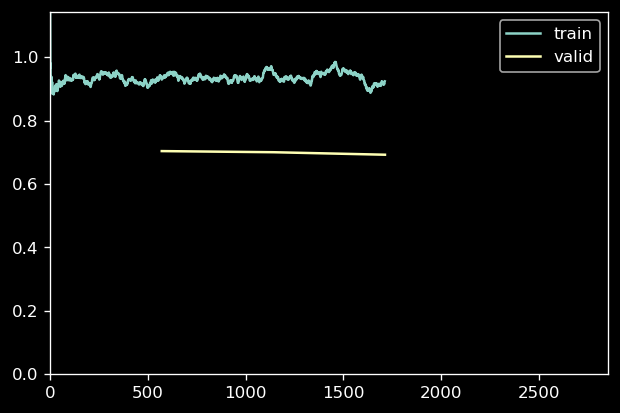

Better model found at epoch 1 with valid_loss value: 0.7004534602165222.
Better model found at epoch 2 with valid_loss value: 0.6925851702690125.
Better model found at epoch 3 with valid_loss value: 0.6717890501022339.
No improvement since epoch -1: early stopping


Better model found at epoch 0 with valid_loss value: 0.12425000220537186.


Better model found at epoch 0 with valid_loss value: 0.12566734850406647.


Better model found at epoch 0 with valid_loss value: 0.125.
Validation on test: [0.6548131704330444, 0.125, 0.875, 0.9706902029522124]


Better model found at epoch 0 with valid_loss value: 0.13264887034893036.


-----------------------------------
------------ SPLIT 5 ------------
-----------------------------------

All Callbacks:  [CutMix, SaveModelCallback, ShowGraphCallback, EarlyStoppingCallback, <class 'fastai.callback.training.GradientClip'>, GradientAccumulation]


Better model found at epoch 0 with valid_loss value: 1.2638710737228394.


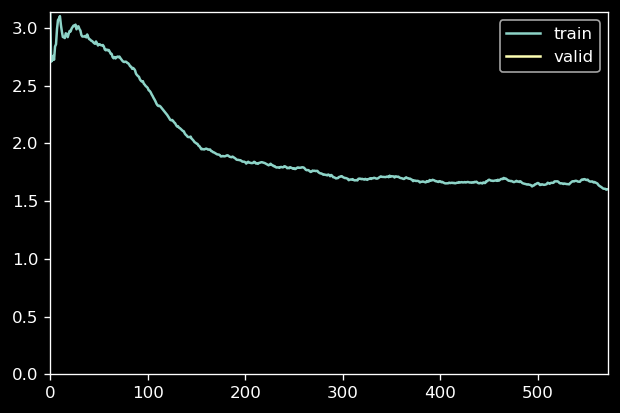

Better model found at epoch 0 with valid_loss value: 0.3917500078678131.
Saved to: ../models/20210223-0550 - arch=densenetblur121d - samples=-1 frozen=1 epochs=5 bs=32 res=300_split_5.pkl
------> EPOCH: 5


Better model found at epoch 0 with valid_loss value: 1.0119240283966064.


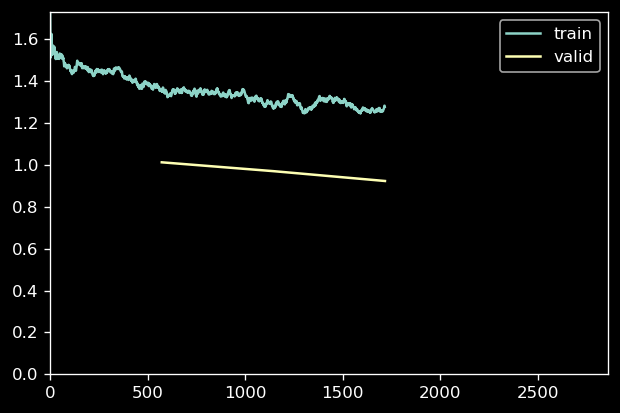

Better model found at epoch 1 with valid_loss value: 0.9697380661964417.
Better model found at epoch 2 with valid_loss value: 0.9227631092071533.
Better model found at epoch 3 with valid_loss value: 0.8587130904197693.
No improvement since epoch -1: early stopping


Better model found at epoch 0 with valid_loss value: 0.16725000739097595.


Better model found at epoch 0 with valid_loss value: 0.18521560728549957.


Better model found at epoch 0 with valid_loss value: 0.1720000058412552.
Validation on test: [0.8469657301902771, 0.1720000058412552, 0.828000009059906, 0.9530298737181049]
------> EPOCH: 10


Better model found at epoch 0 with valid_loss value: 0.8815519213676453.


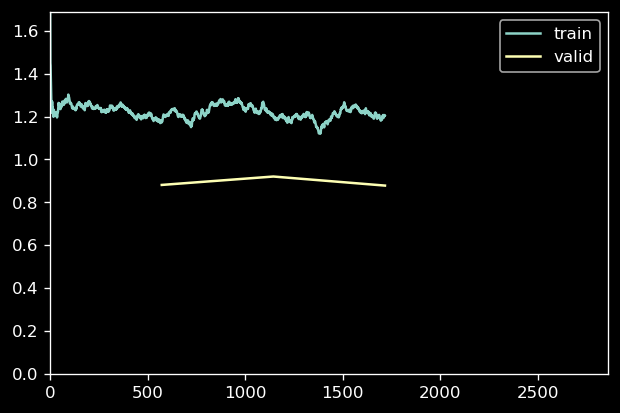

Better model found at epoch 2 with valid_loss value: 0.8784801363945007.
Better model found at epoch 3 with valid_loss value: 0.825412392616272.
No improvement since epoch -1: early stopping


Better model found at epoch 0 with valid_loss value: 0.15674999356269836.


Better model found at epoch 0 with valid_loss value: 0.15564681589603424.


Better model found at epoch 0 with valid_loss value: 0.15549999475479126.
Validation on test: [0.7943369150161743, 0.15549999475479126, 0.8445000052452087, 0.9604794653504509]
------> EPOCH: 15


Better model found at epoch 0 with valid_loss value: 0.8900302648544312.


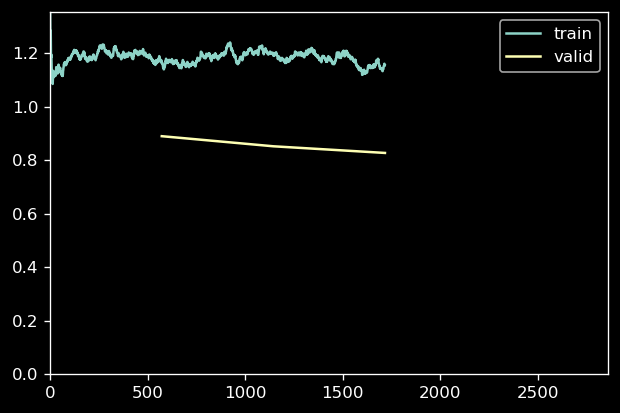

Better model found at epoch 1 with valid_loss value: 0.8522972464561462.
Better model found at epoch 2 with valid_loss value: 0.8274217844009399.
Better model found at epoch 3 with valid_loss value: 0.806857168674469.
No improvement since epoch -1: early stopping


Better model found at epoch 0 with valid_loss value: 0.14374999701976776.


Better model found at epoch 0 with valid_loss value: 0.14743326604366302.


Better model found at epoch 0 with valid_loss value: 0.14249999821186066.
Validation on test: [0.771514356136322, 0.14249999821186066, 0.8575000166893005, 0.9610481372376963]
------> EPOCH: 20


Better model found at epoch 0 with valid_loss value: 0.8282729983329773.


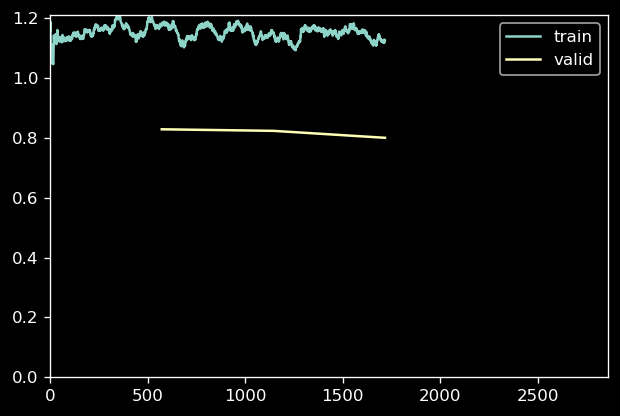

Better model found at epoch 1 with valid_loss value: 0.823092520236969.
Better model found at epoch 2 with valid_loss value: 0.7998721599578857.
Better model found at epoch 3 with valid_loss value: 0.787257969379425.
No improvement since epoch -1: early stopping


Better model found at epoch 0 with valid_loss value: 0.14100000262260437.


Better model found at epoch 0 with valid_loss value: 0.14045174419879913.


Better model found at epoch 0 with valid_loss value: 0.14399999380111694.
Validation on test: [0.7725521326065063, 0.14399999380111694, 0.8560000061988831, 0.9619892363262845]
------> EPOCH: 25


Better model found at epoch 0 with valid_loss value: 0.8263706564903259.


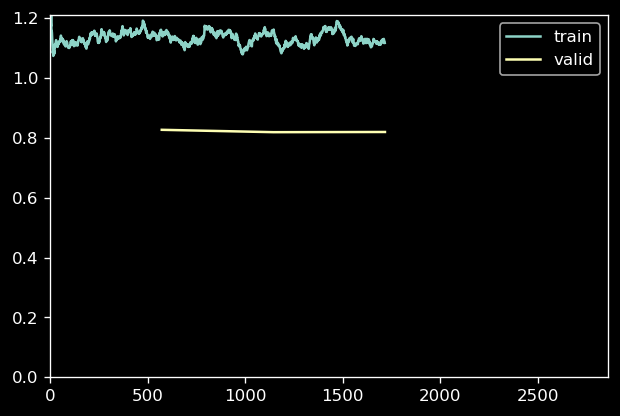

Better model found at epoch 1 with valid_loss value: 0.818478524684906.
Better model found at epoch 3 with valid_loss value: 0.7982661724090576.
No improvement since epoch -1: early stopping


Better model found at epoch 0 with valid_loss value: 0.13824999332427979.


Better model found at epoch 0 with valid_loss value: 0.14537987112998962.


Better model found at epoch 0 with valid_loss value: 0.13824999332427979.
Validation on test: [0.7715600728988647, 0.13824999332427979, 0.8617500066757202, 0.9627575612620459]


Better model found at epoch 0 with valid_loss value: 0.1490759700536728.


-----------------------------------
------------ SPLIT 6 ------------
-----------------------------------

All Callbacks:  [CutMix, SaveModelCallback, ShowGraphCallback, EarlyStoppingCallback, <class 'fastai.callback.training.GradientClip'>, GradientAccumulation]


Better model found at epoch 0 with valid_loss value: 1.060492992401123.


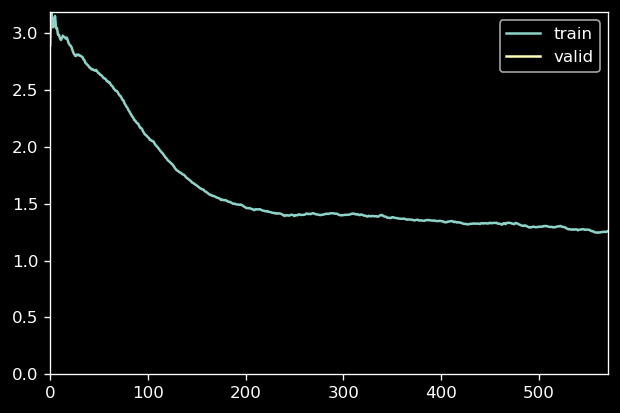

Better model found at epoch 0 with valid_loss value: 0.3190000057220459.
Saved to: ../models/20210223-0550 - arch=densenetblur121d - samples=-1 frozen=1 epochs=5 bs=32 res=300_split_6.pkl
------> EPOCH: 5


Better model found at epoch 0 with valid_loss value: 0.8867805004119873.


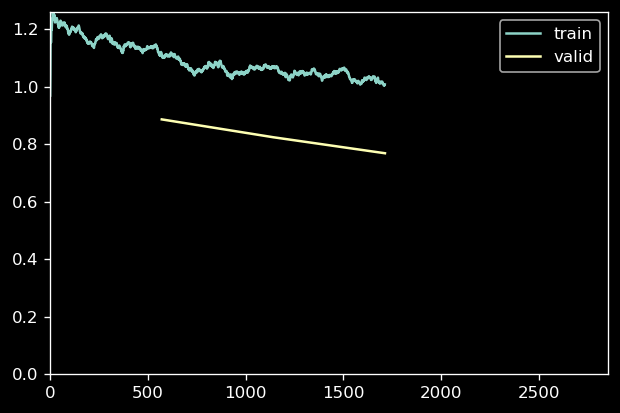

Better model found at epoch 1 with valid_loss value: 0.824619472026825.
Better model found at epoch 2 with valid_loss value: 0.7689967751502991.
Better model found at epoch 3 with valid_loss value: 0.7148947715759277.
No improvement since epoch -1: early stopping


Better model found at epoch 0 with valid_loss value: 0.14374999701976776.


Better model found at epoch 0 with valid_loss value: 0.14496919512748718.


Better model found at epoch 0 with valid_loss value: 0.1469999998807907.
Validation on test: [0.7079081535339355, 0.1469999998807907, 0.8529999852180481, 0.9629108354376303]
------> EPOCH: 10


Better model found at epoch 0 with valid_loss value: 0.7335982322692871.


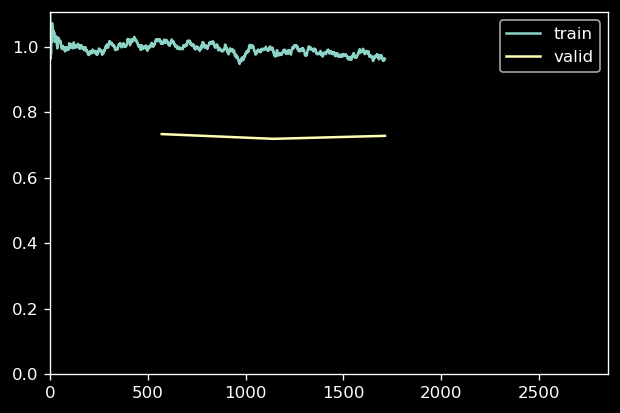

Better model found at epoch 1 with valid_loss value: 0.7190826535224915.
Better model found at epoch 3 with valid_loss value: 0.6936103105545044.
No improvement since epoch -1: early stopping


Better model found at epoch 0 with valid_loss value: 0.13099999725818634.


Better model found at epoch 0 with valid_loss value: 0.12936344742774963.


Better model found at epoch 0 with valid_loss value: 0.13349999487400055.
Validation on test: [0.6849188208580017, 0.13349999487400055, 0.8665000200271606, 0.9677620938842135]
------> EPOCH: 15


Better model found at epoch 0 with valid_loss value: 0.731192946434021.


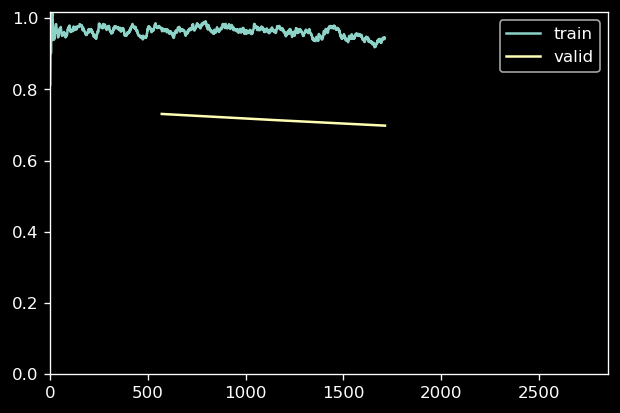

Better model found at epoch 1 with valid_loss value: 0.7141796946525574.
Better model found at epoch 2 with valid_loss value: 0.6983550190925598.
Better model found at epoch 3 with valid_loss value: 0.6775369048118591.
No improvement since epoch -1: early stopping


Better model found at epoch 0 with valid_loss value: 0.12800000607967377.


Better model found at epoch 0 with valid_loss value: 0.12854209542274475.


Better model found at epoch 0 with valid_loss value: 0.13075000047683716.
Validation on test: [0.6709452271461487, 0.13075000047683716, 0.8692499995231628, 0.9695246254390136]
------> EPOCH: 20


Better model found at epoch 0 with valid_loss value: 0.7100960612297058.


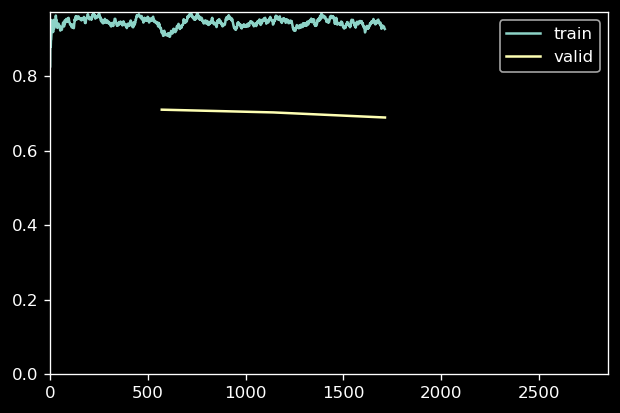

Better model found at epoch 1 with valid_loss value: 0.702739953994751.
Better model found at epoch 2 with valid_loss value: 0.6890875697135925.
Better model found at epoch 3 with valid_loss value: 0.6664875149726868.
No improvement since epoch -1: early stopping


Better model found at epoch 0 with valid_loss value: 0.12075000256299973.


Better model found at epoch 0 with valid_loss value: 0.11704312264919281.


Better model found at epoch 0 with valid_loss value: 0.12025000154972076.
Validation on test: [0.6632369756698608, 0.12025000154972076, 0.8797500133514404, 0.9715985786363662]
------> EPOCH: 25


Better model found at epoch 0 with valid_loss value: 0.6892861127853394.


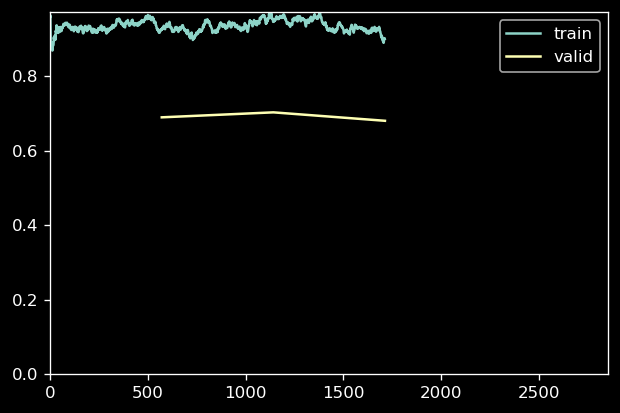

Better model found at epoch 2 with valid_loss value: 0.679999053478241.
Better model found at epoch 3 with valid_loss value: 0.6737134456634521.
No improvement since epoch -1: early stopping


Better model found at epoch 0 with valid_loss value: 0.12549999356269836.


Better model found at epoch 0 with valid_loss value: 0.12073922157287598.


Better model found at epoch 0 with valid_loss value: 0.12475000321865082.
Validation on test: [0.6645324230194092, 0.12475000321865082, 0.875249981880188, 0.9708863030912802]


Better model found at epoch 0 with valid_loss value: 0.1199178621172905.


-----------------------------------
------------ SPLIT 7 ------------
-----------------------------------

All Callbacks:  [CutMix, SaveModelCallback, ShowGraphCallback, EarlyStoppingCallback, <class 'fastai.callback.training.GradientClip'>, GradientAccumulation]


Better model found at epoch 0 with valid_loss value: 1.288238286972046.


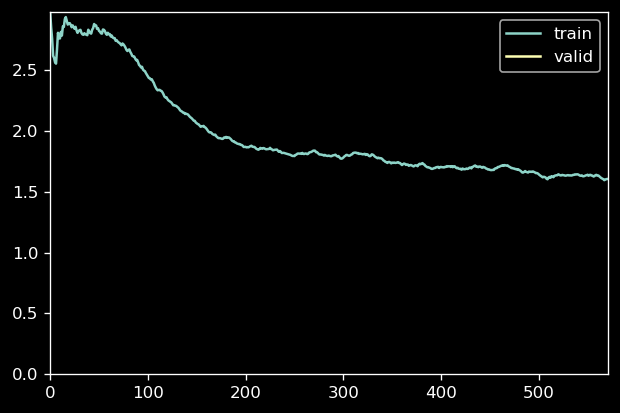

Better model found at epoch 0 with valid_loss value: 0.4505000114440918.
Saved to: ../models/20210223-0550 - arch=densenetblur121d - samples=-1 frozen=1 epochs=5 bs=32 res=300_split_7.pkl
------> EPOCH: 5


Better model found at epoch 0 with valid_loss value: 1.024697184562683.


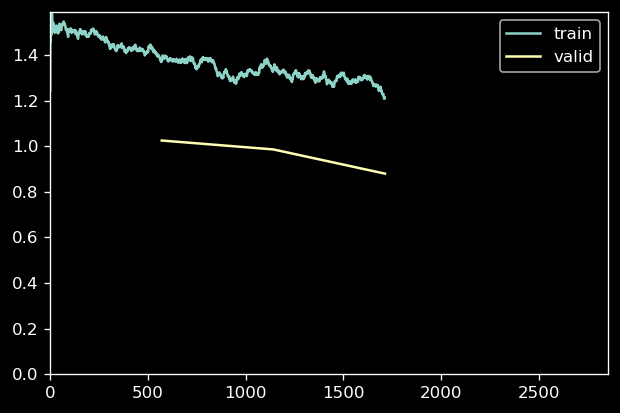

Better model found at epoch 1 with valid_loss value: 0.985648512840271.
Better model found at epoch 2 with valid_loss value: 0.8795550465583801.
Better model found at epoch 3 with valid_loss value: 0.8230549097061157.
No improvement since epoch -1: early stopping


Better model found at epoch 0 with valid_loss value: 0.1914999932050705.


Better model found at epoch 0 with valid_loss value: 0.1815195083618164.


Better model found at epoch 0 with valid_loss value: 0.18774999678134918.
Validation on test: [0.843061089515686, 0.18774999678134918, 0.812250018119812, 0.9538444449597948]
------> EPOCH: 10


Better model found at epoch 0 with valid_loss value: 0.870633065700531.


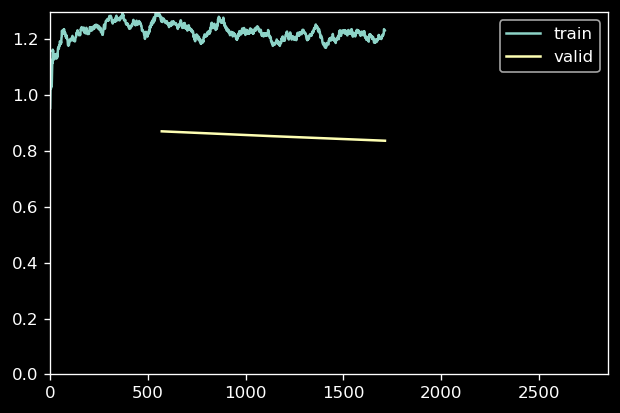

Better model found at epoch 1 with valid_loss value: 0.8531486392021179.
Better model found at epoch 2 with valid_loss value: 0.836942732334137.
Better model found at epoch 3 with valid_loss value: 0.8066533803939819.
No improvement since epoch -1: early stopping


Better model found at epoch 0 with valid_loss value: 0.16574999690055847.


Better model found at epoch 0 with valid_loss value: 0.1642710417509079.


Better model found at epoch 0 with valid_loss value: 0.16175000369548798.
Validation on test: [0.8013004660606384, 0.16175000369548798, 0.8382499814033508, 0.9587679445594631]
------> EPOCH: 15


Better model found at epoch 0 with valid_loss value: 0.8392887115478516.


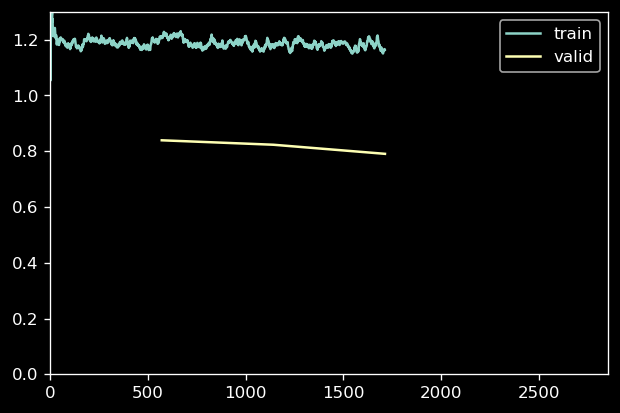

Better model found at epoch 1 with valid_loss value: 0.823330283164978.
Better model found at epoch 2 with valid_loss value: 0.7907260060310364.
Better model found at epoch 3 with valid_loss value: 0.7758498787879944.
No improvement since epoch -1: early stopping


Better model found at epoch 0 with valid_loss value: 0.1407500058412552.


Better model found at epoch 0 with valid_loss value: 0.13963039219379425.


Better model found at epoch 0 with valid_loss value: 0.13875000178813934.
Validation on test: [0.7821387052536011, 0.13875000178813934, 0.8612499833106995, 0.9611710550293807]
------> EPOCH: 20


Better model found at epoch 0 with valid_loss value: 0.8376957774162292.


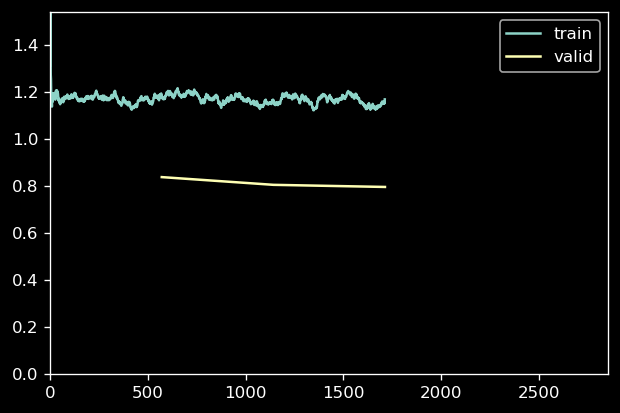

Better model found at epoch 1 with valid_loss value: 0.8048933744430542.
Better model found at epoch 2 with valid_loss value: 0.7958670258522034.
Better model found at epoch 3 with valid_loss value: 0.7597145438194275.
No improvement since epoch -1: early stopping


Better model found at epoch 0 with valid_loss value: 0.13824999332427979.


Better model found at epoch 0 with valid_loss value: 0.13223819434642792.


Better model found at epoch 0 with valid_loss value: 0.14249999821186066.
Validation on test: [0.7593914270401001, 0.14249999821186066, 0.8575000166893005, 0.9626452201915343]
------> EPOCH: 25


Better model found at epoch 0 with valid_loss value: 0.8230180740356445.


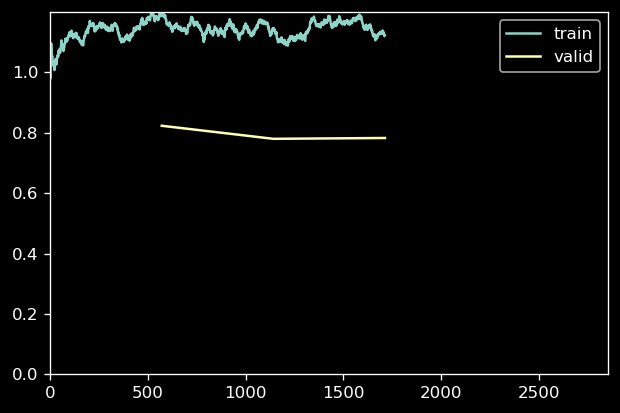

Better model found at epoch 1 with valid_loss value: 0.7798495292663574.
Better model found at epoch 3 with valid_loss value: 0.7554500102996826.
No improvement since epoch -1: early stopping


Better model found at epoch 0 with valid_loss value: 0.13824999332427979.


Better model found at epoch 0 with valid_loss value: 0.1371663212776184.


Better model found at epoch 0 with valid_loss value: 0.14124999940395355.
Validation on test: [0.7526274919509888, 0.14124999940395355, 0.8587499856948853, 0.9656166475437817]


Better model found at epoch 0 with valid_loss value: 0.13264887034893036.


-----------------------------------
------------ SPLIT 8 ------------
-----------------------------------

All Callbacks:  [CutMix, SaveModelCallback, ShowGraphCallback, EarlyStoppingCallback, <class 'fastai.callback.training.GradientClip'>, GradientAccumulation]


Better model found at epoch 0 with valid_loss value: 1.0344524383544922.


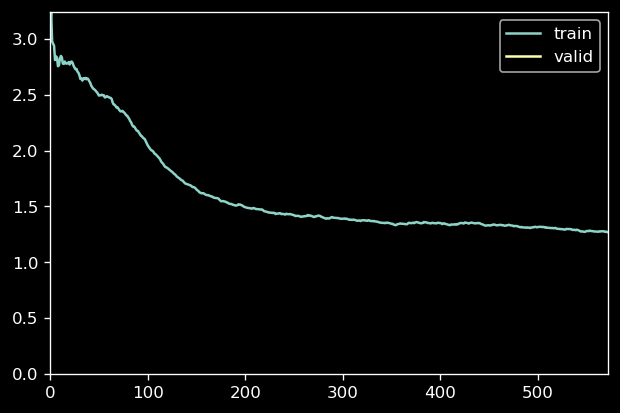

Better model found at epoch 0 with valid_loss value: 0.3075000047683716.
Saved to: ../models/20210223-0550 - arch=densenetblur121d - samples=-1 frozen=1 epochs=5 bs=32 res=300_split_8.pkl
------> EPOCH: 5


Better model found at epoch 0 with valid_loss value: 0.8506193161010742.


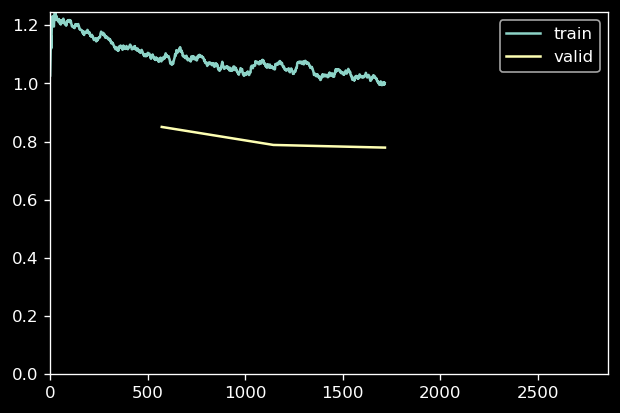

Better model found at epoch 1 with valid_loss value: 0.7887377738952637.
Better model found at epoch 2 with valid_loss value: 0.7795660495758057.
Better model found at epoch 3 with valid_loss value: 0.7286952137947083.
No improvement since epoch -1: early stopping


Better model found at epoch 0 with valid_loss value: 0.14800000190734863.


Better model found at epoch 0 with valid_loss value: 0.15482546389102936.


Better model found at epoch 0 with valid_loss value: 0.14900000393390656.
Validation on test: [0.7171334028244019, 0.14900000393390656, 0.8510000109672546, 0.960959595081347]
------> EPOCH: 10


Better model found at epoch 0 with valid_loss value: 0.732797384262085.


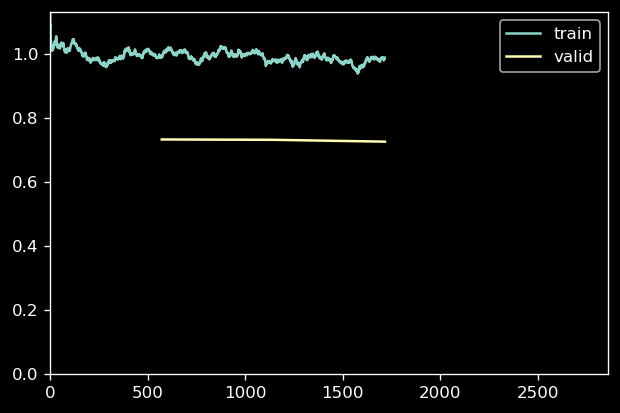

Better model found at epoch 1 with valid_loss value: 0.7316908240318298.
Better model found at epoch 2 with valid_loss value: 0.7259552478790283.
Better model found at epoch 3 with valid_loss value: 0.6980989575386047.
No improvement since epoch -1: early stopping


Better model found at epoch 0 with valid_loss value: 0.13375000655651093.


Better model found at epoch 0 with valid_loss value: 0.13388089835643768.


Better model found at epoch 0 with valid_loss value: 0.14149999618530273.
Validation on test: [0.6859110593795776, 0.14149999618530273, 0.8585000038146973, 0.9659377409502097]
------> EPOCH: 15


Better model found at epoch 0 with valid_loss value: 0.7278331518173218.


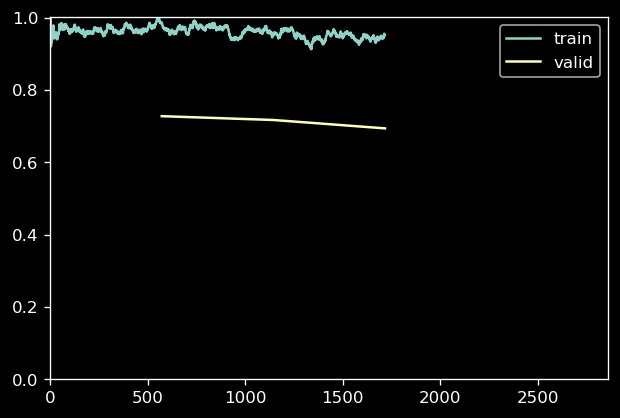

Better model found at epoch 1 with valid_loss value: 0.7172707319259644.
Better model found at epoch 2 with valid_loss value: 0.6940826177597046.
Better model found at epoch 3 with valid_loss value: 0.6829405426979065.
No improvement since epoch -1: early stopping


Better model found at epoch 0 with valid_loss value: 0.12449999898672104.


Better model found at epoch 0 with valid_loss value: 0.13264887034893036.


Better model found at epoch 0 with valid_loss value: 0.12700000405311584.
Validation on test: [0.6661820411682129, 0.12700000405311584, 0.8730000257492065, 0.9691932452417253]
------> EPOCH: 20


Better model found at epoch 0 with valid_loss value: 0.6947051286697388.


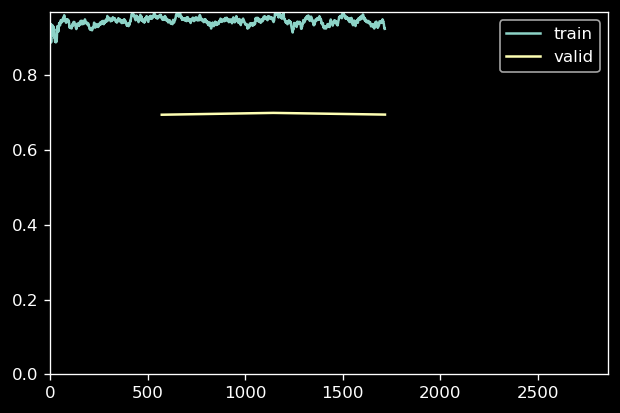

Better model found at epoch 3 with valid_loss value: 0.6749834418296814.
No improvement since epoch -1: early stopping


Better model found at epoch 0 with valid_loss value: 0.12524999678134918.


Better model found at epoch 0 with valid_loss value: 0.12361396104097366.


Better model found at epoch 0 with valid_loss value: 0.12300000339746475.
Validation on test: [0.6579583883285522, 0.12300000339746475, 0.8769999742507935, 0.9707364660393493]
------> EPOCH: 25


Better model found at epoch 0 with valid_loss value: 0.7013610601425171.


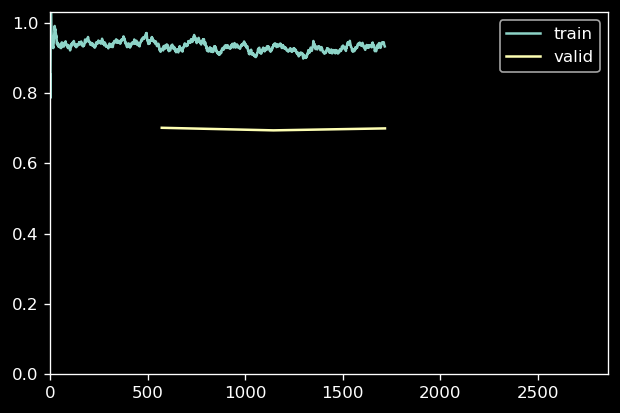

Better model found at epoch 1 with valid_loss value: 0.694060742855072.
Better model found at epoch 3 with valid_loss value: 0.6652486324310303.
No improvement since epoch -1: early stopping


Better model found at epoch 0 with valid_loss value: 0.12075000256299973.


Better model found at epoch 0 with valid_loss value: 0.12279260903596878.


Better model found at epoch 0 with valid_loss value: 0.12349999696016312.
Validation on test: [0.6508835554122925, 0.12349999696016312, 0.8765000104904175, 0.972071554037616]


Better model found at epoch 0 with valid_loss value: 0.12525667250156403.


-----------------------------------
------------ SPLIT 9 ------------
-----------------------------------

All Callbacks:  [CutMix, SaveModelCallback, ShowGraphCallback, EarlyStoppingCallback, <class 'fastai.callback.training.GradientClip'>, GradientAccumulation]


ValueError: Caught ValueError in DataLoader worker process 8.
Original Traceback (most recent call last):
  File "/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 198, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 34, in fetch
    data = next(self.dataset_iter)
  File "/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/fastai/data/load.py", line 110, in create_batches
    yield from map(self.do_batch, self.chunkify(res))
  File "/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/fastcore/basics.py", line 216, in chunked
    res = list(itertools.islice(it, chunk_sz))
  File "/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/fastai/data/load.py", line 125, in do_item
    try: return self.after_item(self.create_item(s))
  File "/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/fastcore/transform.py", line 198, in __call__
    def __call__(self, o): return compose_tfms(o, tfms=self.fs, split_idx=self.split_idx)
  File "/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/fastcore/transform.py", line 150, in compose_tfms
    x = f(x, **kwargs)
  File "/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/fastai/vision/augment.py", line 35, in __call__
    return super().__call__(b, split_idx=split_idx, **kwargs) if self.do else b
  File "/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/fastcore/transform.py", line 73, in __call__
    def __call__(self, x, **kwargs): return self._call('encodes', x, **kwargs)
  File "/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/fastcore/transform.py", line 83, in _call
    return self._do_call(getattr(self, fn), x, **kwargs)
  File "/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/fastcore/transform.py", line 90, in _do_call
    res = tuple(self._do_call(f, x_, **kwargs) for x_ in x)
  File "/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/fastcore/transform.py", line 90, in <genexpr>
    res = tuple(self._do_call(f, x_, **kwargs) for x_ in x)
  File "/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/fastcore/transform.py", line 89, in _do_call
    return retain_type(f(x, **kwargs), x, ret)
  File "/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/fastcore/dispatch.py", line 118, in __call__
    return f(*args, **kwargs)
  File "../utils/augmentation.py", line 23, in encodes
  File "/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/albumentations/core/composition.py", line 182, in __call__
    data = t(force_apply=force_apply, **data)
  File "/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/albumentations/core/composition.py", line 268, in __call__
    data = t(force_apply=True, **data)
  File "/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/albumentations/core/transforms_interface.py", line 89, in __call__
    return self.apply_with_params(params, **kwargs)
  File "/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/albumentations/core/transforms_interface.py", line 102, in apply_with_params
    res[key] = target_function(arg, **dict(params, **target_dependencies))
  File "/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/albumentations/augmentations/crops/transforms.py", line 86, in apply
    return F.center_crop(img, self.height, self.width)
  File "/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/albumentations/augmentations/crops/functional.py", line 115, in center_crop
    raise ValueError(
ValueError: Requested crop size (400, 400) is larger than the image size (347, 797)


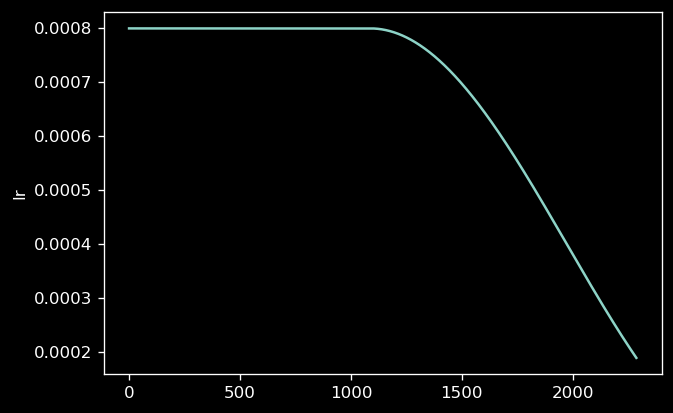

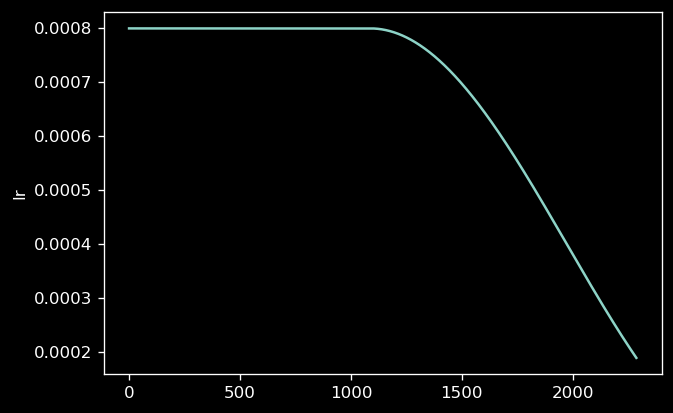

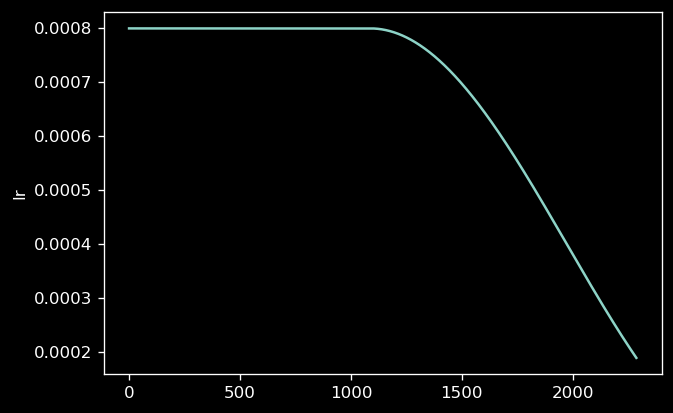

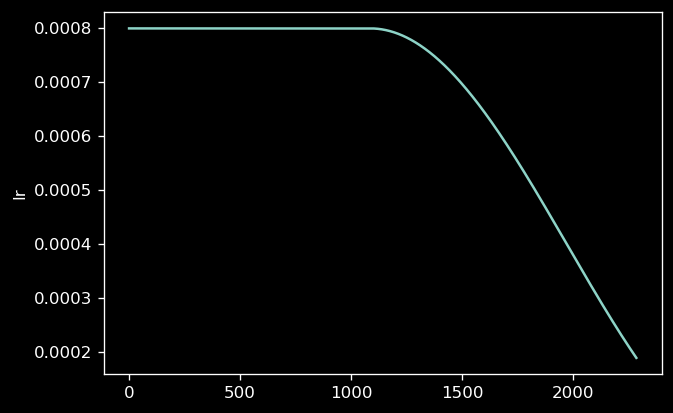

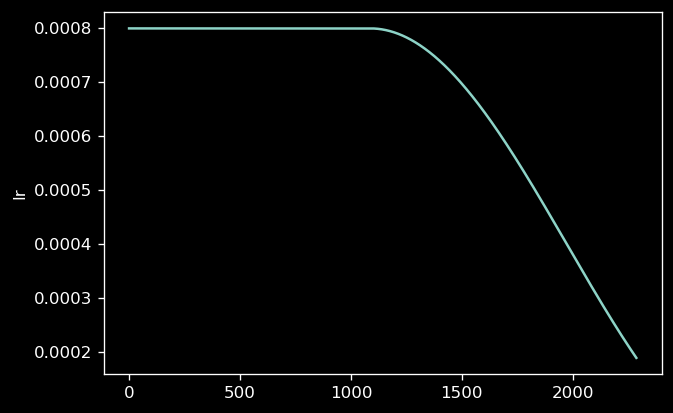

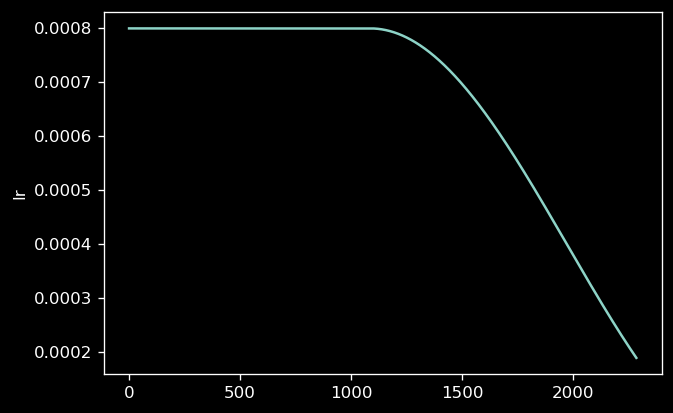

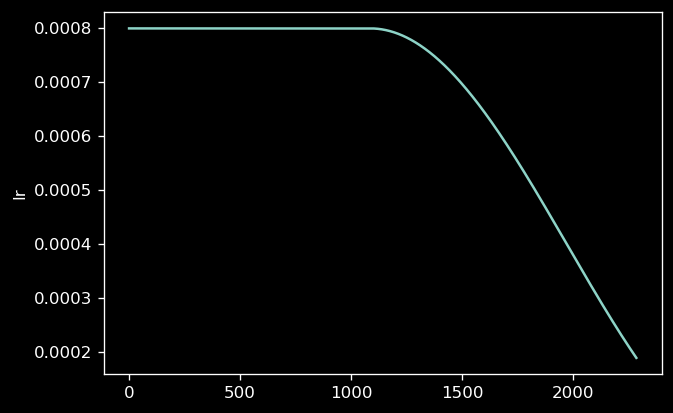

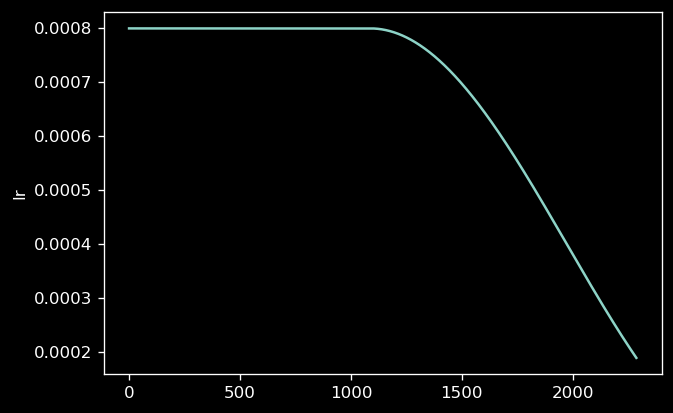

In [50]:
from sklearn.model_selection import StratifiedKFold

LR_CHOICE_UNFROZ = 8e-4
EPOCHS = 5

skf = StratifiedKFold(n_splits=5, random_state = 42, shuffle=True)
i = 0
tw_flag = None
val_pct = []
tst_preds = []

record_df = pd.DataFrame(columns=['RUN_NAME', 'split num', 'epoch', 'loss', 'accuracy', 'roc_auc', 'tuned weights bool'])

for _, val_idx in skf.split(np.array(train_imgs+ensemble_train_imgs), train_labels):
    i += 1
    
    print(f'-----------------------------------')
    print(f'------------ SPLIT {i} ------------')
    print(f'-----------------------------------')

    # sort out the data
    splits = IndexSplitter(val_idx)
    split = splits(train_imgs)
    split_list = [split[0], split[1]]
    split_list.append(L(range(len(train_imgs), len(train_imgs)+len(ensemble_train_imgs))))
    dsrc = Datasets(train_imgs+ensemble_train_imgs, tfms=[[PILImage.create], [get_label, Categorize]],
                  splits=split_list)
    dls = dsrc.dataloaders(bs=BATCH_SIZE, after_item=item_tfms, after_batch=batch_tfms)

    # Create a brand new learner model each time
    if torch.rand(1)[0] > 0.5:
        learn = create_learner(cat_weights=tuned_weights)
        tw_flag = True
    else:
        learn = create_learner(cat_weights=None)
        tw_flag = False
     
    # fit just the new head
    learn.freeze()
    learn.fit_flat_cos(FROZEN_EPOCHS, LR_CHOICE, pct_start=0.99, wd=0.1, reset_opt=True)
    learn.unfreeze()
    
    # persist
#     learn.remove_cbs(CSVLogger)  # temp
    learn.export(f'models/{RUN_NAME}_split_{i}.pkl')
    learn.save(f'{RUN_NAME}_STAGE1_split{i}_acc{round(learn.validate(ds_idx=2)[2],2)}')
    print(f'Saved to: ../models/{RUN_NAME}_split_{i}.pkl')
#     CSVLogger(fname=f'{RUN_NAME}.csv', append=True)  # restore


    # fit a series of short-run models to ensemble later.  Also simulates cos annealing with warm restarts
    for ep in range(5, 30, 5):
        
        print(f'------> EPOCH: {ep}')
        
        if ep < 20:
            learn.fit_flat_cos(EPOCHS, LR_CHOICE_UNFROZ, pct_start=0.38, wd=1e-2, reset_opt=False)
        elif ep < 25:
            learn.fit_flat_cos(EPOCHS, LR_CHOICE_UNFROZ/10, pct_start=0.38, wd=1e-2, reset_opt=False)
        elif ep >= 25
            learn.fit_flat_cos(EPOCHS+3, LR_CHOICE_UNFROZ/100, pct_start=0.38, wd=1e-2, reset_opt=False)

            
               
        # save 
        learn.save(f'{RUN_NAME}_split_{i}_epoch{ep}_acc{round(learn.validate(ds_idx=2)[2],2)}')
        
        # save stats
        val = learn.validate()
        record_df.loc[len(record_df.index)] = [RUN_NAME, i, ep, val[0], val[2], val[3], tw_flag]
        record_df.to_csv(f'CSV-History/{RUN_NAME}_record.csv')
        
        # print validation info
#         print(f'Validation on train: {learn.validate(0)}')
#         print(f'Validation on valid: {val}')
        print(f'Validation on test: {learn.validate(2)}')
   
    learn.recorder.plot_sched()
    
    # Save the validation information to cross validate with
    val_pct.append(learn.validate()[2])
    a,b = learn.get_preds(ds_idx=2)
    tst_preds.append(a)

<br>
<br>

<br>

# -------------------- TRAIN AGAIN -----------------

<br>

<br>
<br>

### Train again

In [ ]:
# save_model("test.pth", learn, learn.opt, with_opt=True)

In [ ]:
# learn = load_learner(f'../models/{RUN_NAME}.pkl', cpu=False)
#
    # RUN_NAME_OF_MODEL_TO_LOAD = '20210210-2234 - arch=tf_efficientnet_b4_ns - samples=1800 frozen=1 epochs=15 bs=12 res=460'
    # EPOCH_TO_LOAD = 9

# load_model(f'models/{RUN_NAME_OF_MODEL_TO_LOAD}_{EPOCH_TO_LOAD}.pth', learn, opt=ranger, with_opt=False)

# load_model(f'models/{RUN_NAME}_8.pth', learn, opt=ranger, with_opt=True)
# learn = load_learner(f'../models/{RUN_NAME}.pkl', cpu=False)
# load_model(f'test.pth', learn, opt=ranger, with_opt=True)

# load_model(f'models/20210213-2138 - arch=efficientnet_b3a - samples=1800 frozen=3 epochs=60 bs=32 res=400_9.pth', learn, opt=ranger, with_opt=True)

learn.dls = dls
learn.remove_cbs(cbs)
learn.add_cbs(cbs)

learn.opt.clear_state()


In [ ]:
learn.unfreeze()

In [ ]:
# learn.dls = dls_findlr
lr_min,lr_steep = learn.lr_find()
plt.axvline(lr_min, ls='--', color='red', label=f'lr_min={round(lr_min,6)}')
# plt.axvline(LR_CHOICE/2, ls='--', color='yellow', label=f'LR_CHOICE/2={round(LR_CHOICE/2,6)}')
plt.axvline(lr_steep, ls='--', color='grey', label=f'lr_steep={round(lr_steep,6)}')
plt.axvline(2e-5, ls='--', color='green', label=f'{round(2e-5,6)}')
plt.axvline(7e-5, ls='--', color='orange', label=f'{round(7e-5,6)}')

plt.legend()
plt.show()


learn.dls = dls
del dls_findlr
gc.collect()
torch.cuda.empty_cache()
gc.collect()


In [ ]:
EPOCHS = 20
LR_CHOICE_UNFROZ = 7e-3

In [ ]:
print(f'EPOCHS:         {EPOCHS}')
print(f'Learning Rate:  {LR_CHOICE_UNFROZ}\n\n')

In [ ]:
# learn.fit_flat_cos(EPOCHS, slice(LR_CHOICE_UNFROZ), pct_start=0.68)

# learn.fit_flat_cos(EPOCHS, LR_CHOICE_UNFROZ, pct_start=0.2, wd=0.1) # , reset_opt=True)
fit_hump(learn, EPOCHS, lr_max=LR_CHOICE_UNFROZ, reset_opt=False)

print(f'Max GPU Memory Allocated: {torch.cuda.max_memory_allocated()/1000000000} GB')
torch.cuda.reset_max_memory_allocated()

<br>
<br>

## Persist the Model

In [ ]:
learn.export(f'../models/{RUN_NAME}.pkl')
print(f'Saved to: ../models/{RUN_NAME}.pkl')

# path = Path('../models')
# path.ls(file_exts='.pkl')

<br>
<br>

### Show some Results

In [ ]:
learn.show_results()


<br>
<hr>
<br>
<br>
<br>

# Validation Set (not test set) Analysis

<br>

### Plot Losses

In [ ]:
# learn.recorder.plot_loss()
# plt.ylabel('Loss')
# plt.xlabel('Batches Processed')

In [53]:
c = learn.cbs

In [54]:
learn.remove_cbs(c)
learn.to_non_native_fp16()

In [55]:
learn.remove_cbs(NonNativeMixedPrecision)

In [56]:
learn.cbs

(#6) [Recorder,CutMix,ShowGraphCallback,GradientClip,ModelToHalf,ModelToHalf]

In [62]:
learn.add_cbs(NonNativeMixedPrecision)

<br>

### Visualize with a confusion Matrix

In [63]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8))

TypeError: lf() got an unexpected keyword argument 'reduction'

In [ ]:
interp.most_confused()[:10]

<br>
<br>

## Classification Report

In [ ]:
interp.print_classification_report()

<br>

### Show the top 15 most error prone images

In [ ]:
interp.plot_top_losses(15, nrows=5)

<br>
<br>
<br>
<br>

# ----------------- Validation ------------

<br>
<br>

<br>

In [ ]:
VALID_RESOLUTION = 400
VALID_BATCH_SIZE = 12

test_learn = learn

# load_learner('../models/{RUN_NAME}.pkl', cpu=False)
# load_model(f'models/{RUN_NAME_OF_MODEL_TO_LOAD}.pth', test_learn, opt=ranger, with_opt=True)


In [ ]:
def get_train_aug_test(): return A.Compose([
            A.RandomResizedCrop(VALID_RESOLUTION,VALID_RESOLUTION, scale=(0.2, 1)),
            A.Transpose(p=0.7),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(p=0.7),
            A.HueSaturationValue(
                hue_shift_limit=0.3, 
                sat_shift_limit=0.3, 
                val_shift_limit=0.3, 
                p=0.7
            ),
            A.RandomBrightnessContrast(
                brightness_limit=(-0.2,0.2), 
                contrast_limit=(-0.2, 0.2), 
                p=0.7
            ),
            A.CoarseDropout(p=0.8, max_holes=20),
            A.Cutout(p=0.8, max_h_size=12, max_w_size=12),
            A.Sharpen(p=0.3, alpha=(0.1,0.3), lightness=(0.3, 0.9))
], p=1.0)



def get_valid_aug_test(): return A.Compose([
    A.Resize(VALID_RESOLUTION, VALID_RESOLUTION, p=1.0),
    A.OneOf([
        A.CenterCrop(VALID_RESOLUTION,VALID_RESOLUTION, always_apply=True),
        A.RandomResizedCrop(VALID_RESOLUTION,VALID_RESOLUTION, scale=(0.4, 0.7), always_apply=True),

        ], p=1.0),
        A.Resize(VALID_RESOLUTION, VALID_RESOLUTION, p=1.0),

            A.HorizontalFlip(p=0.5),

        A.HueSaturationValue(
            hue_shift_limit=0.14, 
            sat_shift_limit=0.14, 
            val_shift_limit=0.14, 
            p=0.5
            ),
        A.RandomBrightnessContrast(
            brightness_limit=(-0.15,0.15), 
            contrast_limit=(-0.1, 0.2), 
            p=0.5
            ),
    A.Sharpen(p=1, alpha=(0.1, 0.3), lightness=(0.3, 0.9))
], p=1.0)

In [ ]:
def get_test_fnames(path):
    return ensemble_train_imgs

In [ ]:
learn.validate(ds_idx=2)

In [ ]:
test_dls = ImageDataLoaders.from_df(ensemble_train_df, folder=data_path/'train_images', seed=42, label_col = 0, fn_col=0, 
                               batch_tfms=batch_tfms, bs=BATCH_SIZE, item_tfms=item_tfms)
test_dl = test_dls.test_dl(ensemble_train_df)

####  Get the Inferrences on the Test Set

In [ ]:
inputs, preds, targs, decoded, losses = test_learn.get_preds(dl=test_dl, with_input=True, with_decoded=True, with_loss=True, reorder=False)


In [ ]:
interp = ClassificationInterpretation(dl=test_dl, inputs=inputs, preds=preds, targs=targs, decoded=decoded, losses=losses )

<br>

### Visualize with a confusion Matrix

In [ ]:
interp.plot_confusion_matrix(figsize=(8,8))

In [ ]:
interp.most_confused()[:10]

<br>
<br>

## Classification Report

In [ ]:
interp.print_classification_report()

In [ ]:
interp.plot_top_losses(k=15)

## Archive this version of the notebook

In [52]:
import os
import shutil

# Allow Jupyter the opportunity to autosave
!sleep 20
# time = '20210122-2356'
# copy the notebook file - the prefix links it to the saved model
shutil.copyfile('DenseNet Cassava Disease Classification-Copy1.ipynb', f'Archive/{time} - DenseNet Cassava Disease Classification.ipynb')

"Archive/<module 'time' (built-in)> - DenseNet Cassava Disease Classification.ipynb"

## Infer on the Kaggle provided test set

In [ ]:
predstta, targstta = test_learn.tta(dl=test_dl, n=3)  #, use_max=False, beta=0.1)
# print(classification_report(df.iloc[:,0], preds.argmax(dim=-1).numpy()))  # TTA

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print(classification_report(predstta.argmax(dim=-1), targstta))

# FIND ALL WRONG FILES

In [ ]:
def get_test_fnames(path):
    return all_files

item_tfms = [AlbumentationsTransform(get_train_aug_test(), get_valid_aug_test())]
batch_tfms = [Normalize.from_stats(*imagenet_stats)]

test_db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_test_fnames,
    get_y=parent_label, 
    item_tfms=item_tfms,
    batch_tfms=batch_tfms)

dls = test_db.dataloaders(get_test_fnames, bs=VALID_BATCH_SIZE)

test_dl = dls.test_dl(get_test_fnames('None'), with_labels=True)

allpreds, alltargs, alldecoded = test_learn.get_preds(dl=test_dl, with_decoded=True)

In [ ]:
inacc_flist = []

for i in range(len(alltargs)):
    if int(alltargs[i]) != int(alldecoded[i]):
        inacc_flist.append(test_dl.items[i])
        
print(f'Number of inaccurate inferrences: {len(inacc_flist)}')
print(f'Percent Accurate:  {1 - (len(inacc_flist) / len(alltargs))}')

        

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

print(classification_report(alltargs, allpreds.argmax(dim=-1)))
# confusion_matrix(alltargs, allpreds.argmax(dim=-1))

In [ ]:
import pickle
with open(f"INACCFLIST_{RUN_NAME_OF_MODEL_TO_LOAD}.p", "wb") as pfile:
    pickle.dump(inacc_flist, pfile)

In [ ]:
test_learn.predict('../data/test_images/2216849948.jpg')